# A notebook for pulling the run data from wandb for TALES and creating the various figures and tables used in our paper and website.

## Data pre-processing
Relevant Variables:
- tmp: dataframe with all of the run info
- framework_games: a dictionary of the form {framework: [all games in framework]}. Useful for checking and making sure that every llm has at least one game run
- llm_framework_scores: a dictionary of the form {llm: {framework: {game: {seed: [best_score, tokens_used]}}}}

### These cells do the following:
- Initialize the wandb api
- Pull all the runs according to certain filters ('conversation: True')
- Dump the runs into a pandas dataframe
- Print the number of total games per llm (This should be 615 if all games were run 615 = 123 * 5)

In [1]:
#Workspace you want to pull runs from
wandb_workspace = "text-games-benchmark"
# wandb_workspace = "tales"

# Where you want the logged format texts to be stored (option for more complicated file structures later down)
base_path = '/root/logs/' + wandb_workspace + '/'

# Divider between each step. Change as wanted
divider_string = "\n************************************************************************************************\n"

In [2]:
import wandb
import os
import json
import numpy as np

api = wandb.Api()

In [3]:
import pandas as pd
filter ={
            "config.conversation": True,
        }

runs = api.runs(path=wandb_workspace, filters = filter)
run_cutoff = "2024-02-0"
files_skipped = 0
path = base_path # Change to your file path
runs_data = []
for run in runs:
    # if 'without-help' not in run.tags:
    run_data = dict(run.summary)
    run_data.update(run.config)
    run_data['tags'] = run.tags
    run_data['run_object'] = run

    # Download the artifact to extract the rollout. This can take a while if you haven't downloaded them before so I would recommend commenting them out if not needed'
    if 'episode/rollout' not in run._summary.keys():
        run_data['rollout'] = ""
        print(f'Missing rollout data for {run.name}')
        continue
    file_path = run._summary['episode/rollout']['path']
    full_path = path + file_path
    try:
        if not os.path.exists(full_path): # If the log has not been downloaded, download it
            print("Downloading file", full_path)
            for file in run.files():
                if "rollout" in file.name:
                    file.download(base_path, exist_ok=True)
        with open(full_path) as json_file: log = json.load(json_file)
        run_data['rollout'] = log['data']
    except:
        files_skipped += 1
        run_data['rollout'] = ""
        try:
            print(f'Missing rollout data for {run.name} {run.game} {run.seed}')
        except:
            print(f'Missing rollout data for {run.name}')

    run_data["agent"] = run.config["agent"]
    run_data["game"] = run.config["game"]
    long_llm = run.config["llm"]
    short_llm = long_llm.split("/")[-1].replace("-03-25", "")
    run_data["llm"] = short_llm
    runs_data.append(run_data)
print(len(runs_data))
runs_df = pd.DataFrame(runs_data)

Missing rollout data for ScienceWorldUseThermometer - ReasoningAgent_gemini-2.5-pro-preview-03-25_s202411061_c100_convTrue_actT0.0_cotT0.0_effortdefault
Missing rollout data for JerichoEnvPentari - ReasoningAgent_gemini-2.5-pro-preview-03-25_s202411062_c100_convTrue_actT0.0_cotT0.0_effortdefault
Missing rollout data for JerichoEnvReverb - ReasoningAgent_gemini-2.5-pro-preview-03-25_s202411062_c100_convTrue_actT0.0_cotT0.0_effortdefault
Missing rollout data for TWXSimonSaysWithMemory10Verbose - ReasoningAgent_gemini-2.5-pro-preview-03-25_s202411062_c100_convTrue_actT0.0_cotT0.0_effortdefault
Missing rollout data for JerichoEnvInfidel - ReasoningAgent_gemini-2.5-pro-preview-03-25_s202411063_c100_convTrue_actT0.0_cotT0.0_effortdefault
Missing rollout data for TWXArithmetic - ReasoningAgent_o4-mini_s202411062_c100_convTrue_actT0.0_cotT0.0_efforthigh
Missing rollout data for JerichoEnvGold - ReasoningAgent_o3_s202411061_c100_convTrue_actT0.0_cotT0.0_effortmedium
Missing rollout data for Jer

In [43]:
# Save for later
# runs_df.to_pickle('run_data_6_1.pkl')

In [4]:
print(runs_df.keys())

Index(['_runtime', '_step', '_timestamp', '_wandb', 'episode/moves',
       'episode/normalized_score', 'episode/rollout', 'episode/score',
       'final/Duration', 'final/Game Max Score', 'final/Highscore',
       'final/Normalized Score', 'total/Env. Steps', 'total/Game Moves',
       'total/Invalid Actions', 'total/Losts', 'total/Resets', 'total/Wins',
       'llm', 'game', 'seed', 'agent', 'context', 'act_temp', 'framework',
       'max_steps', 'conversation', 'admissible_commands', 'tags',
       'run_object', 'rollout', 'total/Tokens', 'cot_temp', 'game_seed',
       'context_limit', 'episode/highscore', 'episode/normalized_highscore',
       'episode/token_usage', 'agent_type', 'version', 'reasoning_effort',
       'total/Prompt Tokens', 'total/Response Tokens', 'total/Thinking Tokens',
       'episode/token_usage_thinking'],
      dtype='object')


In [5]:
# Filter the runs
def regen_and_filter_df(all_games_required = True, all_seeds_required = False, print_counts = False):
    tmp = runs_df
    tmp = tmp[tmp['conversation'] == True]

    if wandb_workspace == 'tales':
        # Llm-walkthrough
        tmp = tmp[tmp['agent_type'] == 'llm-walkthrough']
        tmp = tmp[tmp['walkthrough_mask'].isnull()]
    else:
         # Standard
        tmp1 = tmp[tmp['agent_type'] == 'zero-shot']
        tmp2 = tmp[tmp['agent_type'] == 'react']
        tmp = pd.concat([tmp1, tmp2])


    tmp = tmp[tmp['llm'] != 'claude-3.5-sonnet']
    tmp = tmp[tmp['llm'] != 'o3-mini']
    tmp = tmp[tmp['game'] != 'JerichoEnvTheatre']
    tmp = tmp[~tmp['tags'].apply(lambda tags: 'without-help' in tags)]
    tmp = tmp[tmp['max_steps'] == 100]

    # Check for if there is an llm with multiple agent types: If so, add designation
    llm_agent_counts = tmp.groupby('llm')['agent_type'].nunique()
    llms_with_multiple_types = llm_agent_counts[llm_agent_counts > 1].index.tolist()

    for llm in llms_with_multiple_types:
        for agent_type in tmp[tmp['llm'] == llm]['agent_type'].unique():
            mask = (tmp['llm'] == llm) & (tmp['agent_type'] == agent_type)
            if agent_type == "zero-shot":
                tmp.loc[mask, 'llm'] = f"{llm}"
            else:
                tmp.loc[mask, 'llm'] = f"{llm} (thinking)"

    # Check for if there is an llm with multiple different reasoning efforts: If so, add designation
    llm_reasoning_counts = tmp.groupby('llm')['reasoning_effort'].nunique()
    llms_with_multiple_rEfforts = llm_reasoning_counts[llm_reasoning_counts > 1].index.tolist()
    print(llms_with_multiple_rEfforts)
    for llm in llms_with_multiple_rEfforts:
        for reasoning_effort in tmp[tmp['llm'] == llm]['reasoning_effort'].unique():
            mask = (tmp['llm'] == llm) & (tmp['reasoning_effort'] == reasoning_effort)
            tmp.loc[mask, 'llm'] = f"{llm} ({reasoning_effort})"

    if all_games_required:
        print("Requiring all games...")
        # If the llm has all games, this value should be 
        game_counts = tmp.groupby('llm')['game'].nunique()
        llms_with_enough_games = game_counts[game_counts >= 122].index.tolist()
        tmp = tmp[tmp['llm'].isin(llms_with_enough_games)]

    if all_seeds_required:
        print("Requiring all seeds...(implicitly requiring all games too)")
        seed_counts = tmp[['llm', 'seed', 'game']].groupby('llm').size()
        llms_with_enough_seeds = seed_counts[seed_counts >= 608].index.tolist()
        tmp = tmp[tmp['llm'].isin(llms_with_enough_seeds)]

    llm_counts = tmp[['llm', 'seed', 'game']].groupby('llm').size().reset_index(name='total_games')

    if print_counts: print(llm_counts)

    return tmp

tmp = regen_and_filter_df(all_games_required = True, all_seeds_required = True, print_counts = True)

['o3']
Requiring all games...
Requiring all seeds...(implicitly requiring all games too)
                                       llm  total_games
0                              DeepSeek-R1          610
1            DeepSeek-R1-Distill-Llama-70B          610
2                  Llama-3.1-405B-Instruct          610
3                   Llama-3.1-70B-Instruct          610
4                    Llama-3.1-8B-Instruct          610
5                    Llama-3.2-1B-Instruct          610
6                    Llama-3.2-3B-Instruct          610
7                   Llama-3.3-70B-Instruct          610
8   Llama-4-Maverick-17B-128E-Instruct-FP8          610
9           Llama-4-Scout-17B-16E-Instruct          610
10              Ministral-8B-Instruct-2410          610
11             Mistral-Large-Instruct-2407          610
12         Mistral-Small-24B-Instruct-2501          610
13     Mistral-Small-3.1-24B-Instruct-2503          610
14             Mistral-Small-Instruct-2409          610
15             

### Get a dictionary of the form {llm: {framework: {game: {seed: best_score}}}} to make things easier later

In [6]:
import random
num_runs = 0
num_traj = 0
avg_last_rewarded_step = 0
rewarded_trajs = 0
filtered_runs_data = tmp.to_dict(orient='records')
data = random.choice(filtered_runs_data)
print(data.keys())
all_frameworks = tmp['framework'].unique()
all_llms = tmp['llm'].unique()
print(all_frameworks)
reasoning_models = []
# Could just do tmp['framework'].unique() but this enforces ordering
fws = ['textworld', 'textworld_express', 'alfworld', 'scienceworld', 'jericho']
# store everything in a dictionary of the form {llm: {framework: {game: {seed: best_score}}}}
llm_framework_scores = {} 

# Iniitialize the LLM layer of the dictionary
for llm in all_llms:
    llm_framework_scores[llm] = {}

# Initialize the framework layer of the dictionary
for framework in fws:
    for llm in all_llms:
        llm_framework_scores[llm][framework] = {}   

# For game and seeds, its easier to just iterate through the filtered_runs_data
for data in filtered_runs_data:
    game = data['game']
    seed = data['seed']

    if game not in llm_framework_scores[data['llm']][data['framework']].keys():
        llm_framework_scores[data['llm']][data['framework']][game] = {}
    
    if data['agent_type'] == 'react':
        if data['llm'] not in reasoning_models:
            reasoning_models.append(data['llm'])
    # Get the max score reached
    max_score = -1000000
    if 'rollout' not in data.keys():
        llm_framework_scores[data['llm']][data['framework']][game][seed] = 0
        continue
    for step in data['rollout']:
        if step[3] > max_score:
            max_score = step[3]

    if max_score < 0:
        max_score = data['episode/normalized_highscore']

    tokens_used = data['episode/token_usage']
    llm_framework_scores[data['llm']][data['framework']][game][seed] = [max_score, tokens_used]

# Uncomment to count the number of runs for each LLM to sanity check
# for llm in all_llms:
#     total_runs = 0
#     for framework in fws:
#         relevant_games = llm_framework_scores[llm][framework]
#         for game, seeds in relevant_games.items():
#             total_runs += len(seeds)
#     print("LLM: ", llm)
#     print("Total runs: ", total_runs)
print(reasoning_models)

dict_keys(['_runtime', '_step', '_timestamp', '_wandb', 'episode/moves', 'episode/normalized_score', 'episode/rollout', 'episode/score', 'final/Duration', 'final/Game Max Score', 'final/Highscore', 'final/Normalized Score', 'total/Env. Steps', 'total/Game Moves', 'total/Invalid Actions', 'total/Losts', 'total/Resets', 'total/Wins', 'llm', 'game', 'seed', 'agent', 'context', 'act_temp', 'framework', 'max_steps', 'conversation', 'admissible_commands', 'tags', 'run_object', 'rollout', 'total/Tokens', 'cot_temp', 'game_seed', 'context_limit', 'episode/highscore', 'episode/normalized_highscore', 'episode/token_usage', 'agent_type', 'version', 'reasoning_effort', 'total/Prompt Tokens', 'total/Response Tokens', 'total/Thinking Tokens', 'episode/token_usage_thinking'])
['scienceworld' 'textworld' 'alfworld' 'jericho' 'textworld_express']
['o1', 'claude-3.7-sonnet (thinking)', 'DeepSeek-R1-Distill-Llama-70B', 'DeepSeek-R1', 'o3 (high)', 'Qwen3-32B', 'o3 (low)', 'o3 (medium)']


### Make a dictionary of all frameworks and games
- Useful for when you want to check that every game has at least one run. Of the form {framework: [games]}

In [7]:
# Make a dictionary of the form {framework: [games]} to make things easier
framework_games = {}
for framework in fws:
    framework_games[framework] = []
    for llm in all_llms:
        relevant_games = llm_framework_scores[llm][framework]
        for game, seeds in relevant_games.items():
            if game not in framework_games[framework]:
                framework_games[framework].append(game)

print(framework_games)

{'textworld': ['TWCookingLevel1', 'TWCookingLevel2', 'TWCookingLevel3', 'TWCookingLevel4', 'TWCookingLevel5', 'TWCookingLevel6', 'TWCookingLevel7', 'TWCookingLevel8', 'TWCookingLevel9', 'TWCookingLevel10'], 'textworld_express': ['TWXCookingWorld', 'TWXTextWorldCommonsense', 'TWXCoinCollector', 'TWXArithmetic', 'TWXMapReader', 'TWXSorting', 'TWXSimonSays10', 'TWXSimonSays50', 'TWXSimonSays100', 'TWXSimonSaysWithMemory10', 'TWXSimonSaysWithMemory50', 'TWXSimonSaysWithMemory100', 'TWXSimonSaysWithMemory10Verbose', 'TWXSimonSaysWithMemory50Verbose', 'TWXSimonSaysWithMemory100Verbose', 'TWXPeckingOrder'], 'alfworld': ['ALFWorldPickAndPlaceSimpleSeen', 'ALFWorldLookAtObjInLightSeen', 'ALFWorldPickCleanThenPlaceInRecepSeen', 'ALFWorldPickHeatThenPlaceInRecepSeen', 'ALFWorldPickCoolThenPlaceInRecepSeen', 'ALFWorldPickTwoObjAndPlaceSeen', 'ALFWorldPickAndPlaceSimpleUnseen', 'ALFWorldLookAtObjInLightUnseen', 'ALFWorldPickCleanThenPlaceInRecepUnseen', 'ALFWorldPickHeatThenPlaceInRecepUnseen', 'AL

Checking why a llm is missing

In [8]:
# one_llm = 'gemini-2.5-pro-preview-03-25'
one_llm = 'o3 (medium)'
def get_missing_games_and_seeds(one_llm):
    tmp_one_llms = tmp[tmp['llm'] == one_llm]
    one_llm_games = tmp_one_llms['game'].unique()

    all_games = []
    for _, games in framework_games.items():
        all_games += games

    for game in all_games:
        games = tmp_one_llms[tmp_one_llms['game'] == game]
        if len(games['seed'].unique()) != 5:
            print(f'{one_llm} {game} only has seeds {games["seed"].unique()}')

    missing_games = []
    for game in all_games:
        if game not in one_llm_games:
            missing_games.append(game)
    return missing_games

for llm in tmp['llm'].unique():
    get_missing_games_and_seeds(llm)

## Making and formatting table and charts for overleaf and the website.
- Alot of these I made it so that the output of the cell can just be copy-pasted into the appropriate table
- For updating the website with scores, you should just be able to run everything and the appropriate files will be saved in their respective folders.

### Get all of the scores and stds
- Need to run this for all of the following tables/charts

In [9]:
import numpy as np

def cast_to_float(s):
    try:
        return round(float(s), 3)
    except ValueError:
        return None  # Return None if the conversion fails
    
def get_all_scores_and_stds(llms, frameworks, require_all_frameworks = True, require_all_games = True, require_all_seeds = False, skip_llms = ['claude-3.5-sonnet'], skip_frameworks = [], one_game = "", verbose = False, include_avg = True):
    scores_per_framework = []
    stds_per_framework = []
    # Literate through all llms:
    for llm in llms:
        # Skip the LLMs that are not in the list
        if llm in skip_llms: continue
        # Put the llm in the first position in the list
        scores = [llm]
        stds = [llm]
        all_framework_scores = []
        all_framework_stds = []
        all_frameworks = []

        # If all seeds have not been completed, add a * to the name
        all_seeds_done = True
        for framework in frameworks:
            # Grab the relevant games for the framework
            relevant_games = llm_framework_scores[llm][framework]

            all_tokens = []
            all_scores = []
            all_stds = []
            all_games = []
            for game, seeds in relevant_games.items():
                if len(one_game) > 0:
                    if game not in one_game:
                        continue
                # Get the scores for the game per seed:
                token_seeds = []
                score_seeds = []
                all_games.append(game)
                for score_tokens in seeds.values():
                    score_seeds.append(score_tokens[0])
                    token_seeds.append(score_tokens[1])
                all_scores.append(np.mean(score_seeds))
                if abs(all_scores[-1]) > 100:
                    print(f'{llm} {framework} {game} has score {all_scores[-1]}')
                all_stds.append(np.std(score_seeds))
                all_tokens.append(np.mean(token_seeds))
                all_framework_scores.append(all_scores[-1])
                all_framework_stds.append(all_stds[-1])
                if len(seeds) < 4: 
                    all_seeds_done = False

            # if we are requiring all games, check if we have all the games
            missing_games = []
            if require_all_games:
                for game in framework_games[framework]: 
                    if game not in all_games: missing_games.append(game)
                if len(missing_games) != 0: 
                    if verbose: print(f'{llm} missing games {",".join(missing_games)} in {framework}')
                    continue

            # if we are requiring all seeds, check if we have all the seeds
            if require_all_seeds:
                for game, seeds in relevant_games.items(): 
                    if len(seeds) != 5: missing_games.append(game)
                if len(missing_games) != 0:
                    if verbose: print(f'{llm} missing seeds {",".join(missing_games)} in {framework}')
                    continue

            all_frameworks.append(framework)
            if len(all_scores) > 1:
                scores.append(cast_to_float(np.mean(all_scores)))
                stds.append(cast_to_float(np.mean(all_stds)))

        # if we are requiring all frameworks, check if we have all the frameworks
        if require_all_frameworks:
            if len(scores) != len(frameworks) + 1: # +1 offset for the llm
                missing_frameworks = []
                for framework in frameworks: 
                    if framework not in all_frameworks: missing_frameworks.append(framework)
                if len(missing_frameworks) != 0:
                    if verbose: print(f'{llm} missing frameworks {",".join(missing_frameworks)}')
                    continue

        # Append the per-game mean of all the scores to the end
        if include_avg: scores.append(cast_to_float(np.mean(all_framework_scores)))
        if not all_seeds_done: scores[0] += "*"
        scores_per_framework.append(scores) 

        # Append the per-game mean of all of the standard deviations to the end
        if include_avg: stds.append(cast_to_float(np.mean(all_framework_stds)))
        if not all_seeds_done: stds[0] += "*"
        stds_per_framework.append(stds)
    
    return scores_per_framework, stds_per_framework

scores_per_framework, stds_per_framework = get_all_scores_and_stds(
                                            llms = all_llms, 
                                            frameworks = fws, 
                                            require_all_frameworks = True, 
                                            require_all_games = True, 
                                            require_all_seeds = False, 
                                            skip_llms = ['claude-3.5-sonnet'], 
                                            skip_frameworks = [], 
                                            one_game = "",
                                            verbose = False,
                                            include_avg=True)

scores_per_framework_simon_says, _ = get_all_scores_and_stds(
                                            llms = all_llms, 
                                            frameworks = ['textworld_express'], 
                                            require_all_frameworks = False, 
                                            require_all_games = False, 
                                            require_all_seeds = False, 
                                            skip_llms = ['claude-3.5-sonnet'], 
                                            skip_frameworks = [], 
                                            one_game = ['TWXSimonSays10', 'TWXSimonSays50', 'TWXSimonSays100', 'TWXSimonSaysWithMemory10', 'TWXSimonSaysWithMemory50', 'TWXSimonSaysWithMemory100', 'TWXSimonSaysWithMemory10Verbose', 'TWXSimonSaysWithMemory50Verbose', 'TWXSimonSaysWithMemory100Verbose'],
                                            # one_game = ['TWXSimonSaysWithMemory100'],
                                            verbose = False,
                                            include_avg=True)

print(scores_per_framework_simon_says)

[['Llama-3.1-70B-Instruct', 1.0, 1.0], ['gpt-4o', 1.0, 1.0], ['Qwen2.5-72B-Instruct', 1.0, 1.0], ['Mistral-Large-Instruct-2407', 0.646, 0.646], ['Mistral-Small-Instruct-2409', 0.288, 0.288], ['Mixtral-8x22B-Instruct-v0.1', 0.128, 0.128], ['Mixtral-8x7B-Instruct-v0.1', 0.029, 0.029], ['gpt-4o-mini', 0.998, 0.998], ['Phi-3-mini-128k-instruct', 0.029, 0.029], ['Llama-3.1-405B-Instruct', 0.848, 0.848], ['Llama-3.2-1B-Instruct', 0.338, 0.338], ['Phi-3-medium-128k-instruct', 0.0, 0.0], ['Phi-3.5-mini-instruct', 0.013, 0.013], ['claude-3.5-sonnet-latest', 0.997, 0.997], ['claude-3.5-haiku', 0.998, 0.998], ['Phi-3.5-MoE-instruct', 0.036, 0.036], ['Ministral-8B-Instruct-2410', 0.406, 0.406], ['phi-4', 0.667, 0.667], ['Llama-3.1-8B-Instruct', 0.562, 0.562], ['Qwen2.5-7B-Instruct', 0.616, 0.616], ['Llama-3.2-3B-Instruct', 0.547, 0.547], ['Mistral-Small-24B-Instruct-2501', 0.176, 0.176], ['Llama-3.3-70B-Instruct', 0.985, 0.985], ['Mistral-Small-3.1-24B-Instruct-2503', 0.072, 0.072], ['gemini-2.0-f

In [10]:
print(scores_per_framework)

[['Llama-3.1-70B-Instruct', 0.656, 0.819, 0.083, 0.519, 0.053, 0.32], ['gpt-4o', 0.836, 0.806, 0.567, 0.614, 0.056, 0.406], ['Qwen2.5-72B-Instruct', 0.765, 0.838, 0.367, 0.35, 0.029, 0.307], ['Mistral-Large-Instruct-2407', 0.824, 0.683, 0.067, 0.461, 0.058, 0.303], ['Mistral-Small-Instruct-2409', 0.561, 0.273, 0.0, 0.244, 0.014, 0.148], ['Mixtral-8x22B-Instruct-v0.1', 0.171, 0.084, 0.0, 0.04, 0.004, 0.037], ['Mixtral-8x7B-Instruct-v0.1', 0.0, 0.016, 0.0, 0.04, 0.003, 0.013], ['gpt-4o-mini', 0.565, 0.736, 0.0, 0.272, 0.018, 0.218], ['Phi-3-mini-128k-instruct', 0.027, 0.094, 0.0, 0.024, 0.003, 0.022], ['Llama-3.1-405B-Instruct', 0.909, 0.792, 0.317, 0.518, 0.061, 0.364], ['Llama-3.2-1B-Instruct', 0.0, 0.19, 0.0, 0.024, 0.006, 0.033], ['Phi-3-medium-128k-instruct', 0.0, 0.0, 0.0, 0.023, 0.003, 0.007], ['Phi-3.5-mini-instruct', 0.0, 0.02, 0.0, 0.024, 0.005, 0.01], ['claude-3.5-sonnet-latest', 0.955, 0.816, 0.75, 0.823, 0.096, 0.504], ['claude-3.5-haiku', 0.949, 0.798, 0.267, 0.673, 0.05, 0

Get Pearson Correlation between scores and all llms with a max simon=says score of over 1:

In [11]:
llm_avg_ss_scores = {}
for row in scores_per_framework_simon_says:
    llm_avg_ss_scores[row[0].replace("*", "")] = {'avg': 0, 'ss': row[1]}
    if row[1] > .9:
        print(row[0])

for row in scores_per_framework:
    llm_avg_ss_scores[row[0].replace("*", "")]['avg'] = row[-1]
print(llm_avg_ss_scores)


Llama-3.1-70B-Instruct
gpt-4o
Qwen2.5-72B-Instruct
gpt-4o-mini
claude-3.5-sonnet-latest
claude-3.5-haiku
Llama-3.3-70B-Instruct
gemini-2.0-flash
claude-3.7-sonnet
gpt-4.1
gpt-4.1-mini
claude-3.7-sonnet (thinking)
o3 (low)
{'Llama-3.1-70B-Instruct': {'avg': 0.32, 'ss': 1.0}, 'gpt-4o': {'avg': 0.406, 'ss': 1.0}, 'Qwen2.5-72B-Instruct': {'avg': 0.307, 'ss': 1.0}, 'Mistral-Large-Instruct-2407': {'avg': 0.303, 'ss': 0.646}, 'Mistral-Small-Instruct-2409': {'avg': 0.148, 'ss': 0.288}, 'Mixtral-8x22B-Instruct-v0.1': {'avg': 0.037, 'ss': 0.128}, 'Mixtral-8x7B-Instruct-v0.1': {'avg': 0.013, 'ss': 0.029}, 'gpt-4o-mini': {'avg': 0.218, 'ss': 0.998}, 'Phi-3-mini-128k-instruct': {'avg': 0.022, 'ss': 0.029}, 'Llama-3.1-405B-Instruct': {'avg': 0.364, 'ss': 0.848}, 'Llama-3.2-1B-Instruct': {'avg': 0.033, 'ss': 0.338}, 'Phi-3-medium-128k-instruct': {'avg': 0.007, 'ss': 0.0}, 'Phi-3.5-mini-instruct': {'avg': 0.01, 'ss': 0.013}, 'claude-3.5-sonnet-latest': {'avg': 0.504, 'ss': 0.997}, 'claude-3.5-haiku': 

In [12]:

def calculate_pearson_correlation(items_dict):
    """
    Calculate Pearson correlation coefficient between 'avg' and 'ss' values in a dictionary.
    
    Parameters:
    items_dict -- Dictionary in the format {name: {'avg': value, 'ss': value}, ...}
    
    Returns:
    r -- Pearson correlation coefficient
    """
    # Extract the 'avg' and 'ss' values from the dictionary
    avg_values = [item_data['avg'] for item_data in items_dict.values()]
    ss_values = [item_data['ss'] for item_data in items_dict.values()]
    
    # Number of observations
    n = len(avg_values)
    
    # Check if we have enough data points
    if n < 2:
        return None
    
    # Calculate means
    avg_mean = sum(avg_values) / n
    ss_mean = sum(ss_values) / n
    
    # Calculate the numerator (covariance * n)
    numerator = sum((avg_values[i] - avg_mean) * (ss_values[i] - ss_mean) for i in range(n))
    
    # Calculate the denominators (standard deviations * n)
    avg_variance = sum((x - avg_mean) ** 2 for x in avg_values)
    ss_variance = sum((x - ss_mean) ** 2 for x in ss_values)
    
    # Check for zero variance case
    if avg_variance == 0 or ss_variance == 0:
        return 0  # No correlation if one of the variables doesn't vary
    
    # Calculate Pearson's r
    r = numerator / ((avg_variance * ss_variance) ** 0.5)
    
    return r

print("Pearson correlation: ", calculate_pearson_correlation(llm_avg_ss_scores))

Pearson correlation:  0.8510845101425055


In [13]:
def cast_to_str(value, sig_digits=3):
    if value == 0: return '0.' + '0' * sig_digits
    if value == 100: return '100'
    
    # Count sig figs after decimal
    sig_figs = len(str(value).split(".")[-1])

    # Count zeros to be added:
    trailing_zeros = sig_digits - sig_figs
    
    # Pad zeros
    string_value = str(value)
    for i in range(trailing_zeros): string_value += "0"

    return string_value

def sort_by_last_element(arr):
    return sorted(arr, key=lambda x: x[-1], reverse = True)

# sorted_array = sort_by_last_element(scores_per_framework)
sorted_array = sort_by_last_element(scores_per_framework)
print("Model, Textworld, Textworld_express, Alfworld, Scienceworld, Jericho, Overall")

# Padding them to have the &s line up because it makes my ocd happy
formatted_rows = []
for model in sorted_array:
    formattedRow = [model[0].split("/")[-1]]
    for score in model[1:]:
        formattedRow.append(cast_to_str(cast_to_float(score * 100), 1))
    formatted_rows.append(formattedRow)

print(len(formatted_rows))

Model, Textworld, Textworld_express, Alfworld, Scienceworld, Jericho, Overall
40


### Print out a latex-formatted table of scores: Table 3

In [55]:
reasoning = tmp[tmp['agent_type'] == 'react']['llm'].unique()
reasoning_short = []
for model in reasoning:
    reasoning_short.append(model.split("/")[-1])
zero_shot = tmp[tmp['agent_type'] == 'zero-shot']['llm'].unique()
zero_shot_short = []
for model in zero_shot:
    zero_shot_short.append(model.split('/')[-1])
max_model_len = max([len(row[0]) for row in formatted_rows])
downsampled_top_ten_llms = []
print("Model, Textworld, Textworld_express, Alfworld, Scienceworld, Jericho, Overall")
selected_llms = []
adding_llms = True
for row in formatted_rows:
    scores = " & " +  " & ".join(row[1:])
    # if row[0] in reasoning_short:
    print(f"{row[0]:<{max_model_len + 2}} {scores} \\\\")
    if adding_llms:
        selected_llms.append(row[0])
    if 'gpt-4o-mini' in row[0]:
        adding_llms = False
    if len(downsampled_top_ten_llms) < 10:
        downsampled_top_ten_llms.append(row[0])

print(len(downsampled_top_ten_llms))
print(selected_llms)

Model, Textworld, Textworld_express, Alfworld, Scienceworld, Jericho, Overall
o3 (medium)                               & 100 & 91.9 & 88.3 & 93.0 & 15.7 & 58.7 \\
o3 (high)                                 & 100 & 89.6 & 81.7 & 93.1 & 16.1 & 58.0 \\
o3 (low)                                  & 99.1 & 89.8 & 70.0 & 88.3 & 14.2 & 54.8 \\
claude-3.7-sonnet (thinking)              & 97.3 & 91.3 & 83.3 & 76.5 & 12.5 & 52.5 \\
claude-3.7-sonnet                         & 97.3 & 95.8 & 81.7 & 72.4 & 13.0 & 52.1 \\
claude-3.5-sonnet-latest                  & 95.5 & 81.6 & 75.0 & 82.3 & 9.6 & 50.4 \\
gpt-4.1                                   & 95.3 & 92.5 & 83.3 & 76.1 & 6.8 & 49.9 \\
o1                                        & 97.8 & 70.2 & 28.3 & 80.1 & 10.3 & 44.2 \\
gpt-4o                                    & 83.6 & 80.6 & 56.7 & 61.4 & 5.6 & 40.6 \\
claude-3.5-haiku                          & 94.9 & 79.8 & 26.7 & 67.3 & 5.0 & 39.6 \\
Llama-3.1-405B-Instruct                   & 90.9 & 79.2 & 

In [31]:

model_to_company = {
    # Anthropic models
    "claude-3.7-sonnet": "Anthropic",
    "claude-3.5-sonnet-latest": "Anthropic",
    "claude-3.5-haiku": "Anthropic",
    
    # OpenAI models
    "gpt-4.1": "OpenAI",
    "gpt-4o": "OpenAI",
    "gpt-4.1-mini": "OpenAI",
    "gpt-4o-mini": "OpenAI",
    "gpt-4.1-nano": "OpenAI",
    "o1": "OpenAI",
    "o3 (medium)": "OpenAI",
    "o3 (high)": "OpenAI",
    "o3 (low)": "OpenAI",
    "o4-mini": "OpenAI",
    
    # Meta models (Llama)
    "Llama-3.1-405B-Instruct": "Meta",
    "Llama-3.3-70B-Instruct": "Meta",
    "Llama-3.1-70B-Instruct": "Meta",
    "Llama-4-Scout-17B-16E-Instruct": "Meta",
    "Llama-4-Maverick-17B-128E-Instruct-FP8": "Meta",
    "Llama-3.1-8B-Instruct": "Meta",
    "Llama-3.2-3B-Instruct": "Meta",
    "Llama-3.2-1B-Instruct": "Meta",
    
    # Google models
    "gemini-2.5-pro-preview": "Google",
    "gemini-2.0-flash": "Google",
    
    # Mistral AI models
    "Mistral-Large-Instruct-2407": "Mistral AI",
    "Mistral-Small-Instruct-2409": "Mistral AI",
    "Mistral-Small-24B-Instruct-2501": "Mistral AI",
    "Ministral-8B-Instruct-2410": "Mistral AI",
    "Mistral-Small-3.1-24B-Instruct-2503": "Mistral AI",
    "Mixtral-8x22B-Instruct-v0.1": "Mistral AI",
    "Mixtral-8x7B-Instruct-v0.1": "Mistral AI",
    
    # Microsoft models
    "phi-4": "Microsoft",
    "Phi-3-mini-128k-instruct": "Microsoft",
    "Phi-3.5-MoE-instruct": "Microsoft",
    "Phi-4-mini-instruct": "Microsoft",
    "Phi-3.5-mini-instruct": "Microsoft",
    "Phi-3-medium-128k-instruct": "Microsoft",
    
    # Alibaba models
    "Qwen3-32B": "Alibaba",
    "Qwen2.5-72B-Instruct": "Alibaba",
    "Qwen2.5-7B-Instruct": "Alibaba",
    
    # DeepSeek models
    "DeepSeek-R1": "DeepSeek",
    "DeepSeek-R1-Distill-Llama-70B": "DeepSeek",
    
    # Text-based environments (not LLMs but research environments)
    "Textworld": "Microsoft Research",
    "Textworld_express": "Microsoft Research",
    "Alfworld": "University of Washington",
    "Scienceworld": "Allen Institute for AI",
    "Jericho": "Microsoft Research"
}

Get difficulty of each game:

In [16]:
# all_fws = tmp['framework'].unique()
# framework_best_llm = {}
# for fw in all_fws:
#     llm_scores = tmp[tmp['framework'] == fw]
#     framework_scores = llm_scores.groupby("llm")['episode/normalized_highscore'].mean().reset_index()
#     top_score_row = framework_scores['episode/normalized_highscore'].idxmax()
#     top_llm = framework_scores.loc[top_score_row, 'llm']
#     framework_best_llm[fw] = top_llm    

# print(framework_best_llm)
# Get all frames
all_games = tmp['game'].unique()
print(tmp.keys())
game_avg_score_llm = {}

for game in all_games:
    all_game_scores = {}
    # Also get the top scoring llm per game
    for llm in all_llms:
        llm_scores = tmp[tmp['llm']==llm]
        game_scores = llm_scores[llm_scores['game'] == game]['episode/normalized_highscore'].reset_index()
        game_scores.columns = ["filler", 'episode/normalized_highscore']
        game_score = game_scores['episode/normalized_highscore'].mean()

        game_steps = llm_scores[llm_scores['game'] == game]['total/Env. Steps'].reset_index()
        game_steps.columns = ['filler', 'Steps']
        game_steps = game_steps['Steps'].mean()

        all_game_scores[llm] = (game_score, game_steps)

    game_avg_score_llm[game] = all_game_scores
        

Index(['_runtime', '_step', '_timestamp', '_wandb', 'episode/moves',
       'episode/normalized_score', 'episode/rollout', 'episode/score',
       'final/Duration', 'final/Game Max Score', 'final/Highscore',
       'final/Normalized Score', 'total/Env. Steps', 'total/Game Moves',
       'total/Invalid Actions', 'total/Losts', 'total/Resets', 'total/Wins',
       'llm', 'game', 'seed', 'agent', 'context', 'act_temp', 'framework',
       'max_steps', 'conversation', 'admissible_commands', 'tags',
       'run_object', 'rollout', 'total/Tokens', 'cot_temp', 'game_seed',
       'context_limit', 'episode/highscore', 'episode/normalized_highscore',
       'episode/token_usage', 'agent_type', 'version', 'reasoning_effort',
       'total/Prompt Tokens', 'total/Response Tokens', 'total/Thinking Tokens',
       'episode/token_usage_thinking'],
      dtype='object')


In [17]:
# Now print a table of the form game, avg score, avg steps, top performing model, best score, best steps
sorted_game_avg_score_topLLM_topLLMScore = []
for game, llm_scores in game_avg_score_llm.items():
    items_arr = [game]
    max_score = -1000
    min_steps = 100000
    best_llm = ""
    all_scores = []
    all_steps = []
    for llm, score_step in llm_scores.items():
        avg_score = score_step[0]
        all_scores.append(avg_score)
        avg_step = score_step[1]
        all_steps.append(avg_step)
        if avg_score > max_score:
            max_score = avg_score
            min_steps = avg_step
            best_llm = llm
        elif avg_score == max_score:
            if avg_step < min_steps:
                min_steps = avg_step
                best_llm = llm

    items_arr.append(float(round(np.mean(all_scores) * 100, 2)))
    items_arr.append(float(round(np.mean(all_steps), 1)))
    if (np.mean(all_scores) - 0.0) < .0001:
        items_arr.append("None")
        items_arr.append("N/A")
        items_arr.append("N/A")
    else:
        items_arr.append(best_llm)
        items_arr.append(float(round(max_score * 100, 1)))
        items_arr.append(float(round(min_steps, 1)))
    sorted_game_avg_score_topLLM_topLLMScore.append(items_arr)

sorted_game_avg_score_topLLM_topLLMScore = sorted(sorted_game_avg_score_topLLM_topLLMScore, key=lambda x: x[1] if len(x) > 1 else None, reverse=False)
print("0.) [game, avg score, avg steps, top performing model, best score, best steps]")
# for i, row in enumerate(sorted_game_avg_score_topLLM_topLLMScore):
#     print(f'{i+1}.) {row}')

0.) [game, avg score, avg steps, top performing model, best score, best steps]


In [18]:
def get_all_games_per_framework(tmp, framework):
    llm_games = {}

    all_games = sorted(framework_games[framework])
    print(len(all_games))

    for llm in tmp['llm'].unique():
        llm_name_formatted = llm.split("/")[-1]
        game_scores = []
        for game in all_games:
            # Basing this on Marc's code
            llm_filtered_tmp = tmp[tmp['llm'] == llm]
            framework_filtered_tmp = llm_filtered_tmp[llm_filtered_tmp['game'] == game]
            avg_score = framework_filtered_tmp.groupby("seed")['episode/normalized_highscore'].mean().reset_index()
            avg_score.columns = ["seeds", "avg_normalized_highscore_per_episode"]
            game_scores.append(avg_score['avg_normalized_highscore_per_episode'].mean())

        llm_games[llm_name_formatted] = game_scores

    return llm_games, all_games

def generate_latex_table(table_string):
    # Split the string into lines and extract the header and rows
    lines = [line.strip() for line in table_string.strip().splitlines() if line.strip()]
    headers = [h.strip() for h in lines[0].split("&")]
    rows = [line.rstrip("\\").strip().split("&") for line in lines[1:]]

    # Clean up each row value
    cleaned_rows = [[cell.strip() for cell in row] for row in rows]

    # Start LaTeX table
    latex = []
    latex.append("\\begin{table}[ht]")
    latex.append("\\centering")
    latex.append("\\scriptsize")
    latex.append("\\setlength{\\tabcolsep}{3pt}")
    latex.append("\\renewcommand{\\arraystretch}{1.1}")
    latex.append("\\begin{tabular}{\\textwidth}{l" + "c" * (len(headers) - 1) + "}")
    latex.append("\\toprule")

    # Format header row
    formatted_headers = [headers[0]] + [f"\\rotatebox{{280}}{{{h}}}" for h in headers[1:]]
    latex.append(" & ".join(formatted_headers) + " \\\\")
    latex.append("\\midrule")

    # Format each data row
    for row in cleaned_rows:
        latex.append(" & ".join(row) + " \\\\")

    # Close table
    latex.append("\\bottomrule")
    latex.append("\\end{tabular}")
    latex.append("\\caption{Model performance across TWX tasks}")
    latex.append("\\label{tab:twx-models}")
    latex.append("\\end{table}")

    return "\n".join(latex)
            
all_games, game_titles  = get_all_games_per_framework(tmp, 'textworld')
header = " & ".join(["Models"] + game_titles)
for row in formatted_rows:
    scores = []
    for score in all_games[row[0]]:
        scores.append(cast_to_str(round(score * 100, 1), 1))
    all_scores_framework = "& " + " & ".join(scores)
    header += "\n" + f"{row[0]:<{max_model_len + 2}} {all_scores_framework} \\\\"

print(generate_latex_table(header).replace("TW", ""))
print(len(formatted_rows))

10
\begin{table}[ht]
\centering
\scriptsize
\setlength{\tabcolsep}{3pt}
\renewcommand{\arraystretch}{1.1}
\begin{tabular}{\textwidth}{lcccccccccc}
\toprule
Models & \rotatebox{280}{CookingLevel1} & \rotatebox{280}{CookingLevel10} & \rotatebox{280}{CookingLevel2} & \rotatebox{280}{CookingLevel3} & \rotatebox{280}{CookingLevel4} & \rotatebox{280}{CookingLevel5} & \rotatebox{280}{CookingLevel6} & \rotatebox{280}{CookingLevel7} & \rotatebox{280}{CookingLevel8} & \rotatebox{280}{CookingLevel9} \\
\midrule
o3 (medium) & 100 & 100 & 100 & 100 & 100 & 100 & 100 & 100 & 100 & 100 \\
o3 (high) & 100 & 100 & 100 & 100 & 100 & 100 & 100 & 100 & 100 & 100 \\
o3 (low) & 100 & 90.9 & 100 & 100 & 100 & 100 & 100 & 100 & 100 & 100 \\
claude-3.7-sonnet (thinking) & 100 & 72.7 & 100 & 100 & 100 & 100 & 100 & 100 & 100 & 100 \\
claude-3.7-sonnet & 100 & 72.7 & 100 & 100 & 100 & 100 & 100 & 100 & 100 & 100 \\
claude-3.5-sonnet-latest & 100 & 54.5 & 100 & 100 & 100 & 100 & 100 & 100 & 100 & 100 \\
gpt-4.1 &

In [19]:
print(tmp.keys())
# Practicing doing this with pandas:
def get_avg_tokens_per_llm_framework(tmp):
    # Using dictionary to enforce llm ordering to keep in the same order as the avg scores:
    llm_framework_tokens = {}
    for llm in tmp['llm'].unique():
        llm_name_formatted = llm.split("/")[-1]
        llm_framework_tokens[llm_name_formatted] = {}
        for framework in fws:
            # Basing this on Marc's code
            llm_filtered_tmp = tmp[tmp['llm'] == llm]
            framework_filtered_tmp = llm_filtered_tmp[llm_filtered_tmp['framework'] == framework]
            # avg_tokens = framework_filtered_tmp.groupby("seed")['total/Tokens'].mean().reset_index()
            avg_tokens = framework_filtered_tmp.groupby("seed")['episode/normalized_highscore'].mean().reset_index()
            avg_tokens.columns = ["seeds", "avg_tokens_per_episode"]
            llm_framework_tokens[llm_name_formatted][framework] = (avg_tokens['avg_tokens_per_episode'].mean(), 
                                                         avg_tokens['avg_tokens_per_episode'].std())
            
    return llm_framework_tokens

llm_framework_tokens = get_avg_tokens_per_llm_framework(tmp)
all = 0
for row in formatted_rows:
    tokens = []
    for framework in fws:
        # tokens.append(cast_to_str(round(llm_framework_tokens[row[0].replace("*", "")][framework][0] * 100, 1), 1))
        tokens.append(cast_to_str(round(llm_framework_tokens[row[0].replace("*", "")][framework][1] * 100, 1), 1))
    all_tokens_framework = "& " + " & ".join(tokens)
    print(f"{row[0]:<{max_model_len + 2}} {all_tokens_framework} \\\\")
    all += 1

print(all)

Index(['_runtime', '_step', '_timestamp', '_wandb', 'episode/moves',
       'episode/normalized_score', 'episode/rollout', 'episode/score',
       'final/Duration', 'final/Game Max Score', 'final/Highscore',
       'final/Normalized Score', 'total/Env. Steps', 'total/Game Moves',
       'total/Invalid Actions', 'total/Losts', 'total/Resets', 'total/Wins',
       'llm', 'game', 'seed', 'agent', 'context', 'act_temp', 'framework',
       'max_steps', 'conversation', 'admissible_commands', 'tags',
       'run_object', 'rollout', 'total/Tokens', 'cot_temp', 'game_seed',
       'context_limit', 'episode/highscore', 'episode/normalized_highscore',
       'episode/token_usage', 'agent_type', 'version', 'reasoning_effort',
       'total/Prompt Tokens', 'total/Response Tokens', 'total/Thinking Tokens',
       'episode/token_usage_thinking'],
      dtype='object')
o3 (medium)                              & 0.0 & 2.7 & 4.6 & 2.2 & 0.5 \\
o3 (high)                                & 0.0 & 3.2 & 9.1 

In [20]:
llms_ordered = []
for row in formatted_rows:
    llms_ordered.append(row[0])

In [21]:
games = ['TWCookingLevel1', 'TWCookingLevel2', 'TWCookingLevel3', 'TWCookingLevel4', 'TWCookingLevel5', 'TWCookingLevel6', 'TWCookingLevel7', 'TWCookingLevel8', 'TWCookingLevel9', 'TWCookingLevel10']
tmp = regen_and_filter_df(all_games_required = True, all_seeds_required = True, print_counts = False)
# llm_filtered=tmp[tmp['llm'] == 'gemini-2.0-flash']
max_games = 50
current_framework = 'textworld_express'
current_framework = 'alfworld'
current_framework = 'scienceworld'
current_framework = 'jericho'
if current_framework == 'scienceworld':
    max_games = 15
elif current_framework == 'jericho':
    max_games = 27
games = sorted(tmp[tmp['framework'] == current_framework]['game'].unique())
print(games[:max_games])
print(len(games[:max_games]))
for llm in llms_ordered:
    llm_filtered=tmp[tmp['llm'] == llm]
    llm_filtered = llm_filtered[llm_filtered['framework'] == current_framework]
    # games = llm_filtered['game'].unique()
    # avg_tokens = framework_filtered_tmp.groupby("seed")['total/Tokens'].mean().reset_index()
    scores = [llm]
    for game in games[:max_games]:
        game_filtered = llm_filtered[llm_filtered['game'] == game]
        avg_tokens = game_filtered.groupby("seed")['episode/normalized_highscore'].mean().reset_index()
        avg_tokens.columns = ["seeds", "avg_tokens_per_episode"]
        avg_tokens['avg_tokens_per_episode']
        scores.append(str(round(float(avg_tokens['avg_tokens_per_episode'].mean()) * 100, 1)))

    print(" & ".join(scores), "\\\\")

if len(games) > max_games:
    print("_____________________________________________________")
    print("_____________________________________________________")
    games = sorted(tmp[tmp['framework'] == current_framework]['game'].unique())
    print(games[max_games:])
    print(len(games[max_games:]))
    for llm in llms_ordered:
        llm_filtered=tmp[tmp['llm'] == llm]
        llm_filtered = llm_filtered[llm_filtered['framework'] == current_framework]
        # games = llm_filtered['game'].unique()
        # avg_tokens = framework_filtered_tmp.groupby("seed")['total/Tokens'].mean().reset_index()
        scores = [llm]
        for game in games[max_games:]:
            game_filtered = llm_filtered[llm_filtered['game'] == game]
            avg_tokens = game_filtered.groupby("seed")['episode/normalized_highscore'].mean().reset_index()
            avg_tokens.columns = ["seeds", "avg_tokens_per_episode"]
            avg_tokens['avg_tokens_per_episode']
            scores.append(str(round(float(avg_tokens['avg_tokens_per_episode'].mean()) * 100, 1)))

        print(" & ".join(scores), "\\\\")



['o3']
Requiring all games...
Requiring all seeds...(implicitly requiring all games too)
['JerichoEnv905', 'JerichoEnvAcorncourt', 'JerichoEnvAdvent', 'JerichoEnvAdventureland', 'JerichoEnvAfflicted', 'JerichoEnvAnchor', 'JerichoEnvAwaken', 'JerichoEnvBalances', 'JerichoEnvBallyhoo', 'JerichoEnvCurses', 'JerichoEnvCutthroat', 'JerichoEnvDeephome', 'JerichoEnvDetective', 'JerichoEnvDragon', 'JerichoEnvEnchanter', 'JerichoEnvEnter', 'JerichoEnvGold', 'JerichoEnvHhgg', 'JerichoEnvHuntdark', 'JerichoEnvInfidel', 'JerichoEnvInhumane', 'JerichoEnvJewel', 'JerichoEnvKarn', 'JerichoEnvLibrary', 'JerichoEnvLoose', 'JerichoEnvLostpig', 'JerichoEnvLudicorp']
27
o3 (medium) & 100.0 & 100.0 & 20.6 & 11.2 & 18.9 & 1.6 & 0.0 & 23.5 & 1.0 & 0.8 & 13.6 & 7.0 & 33.3 & 4.8 & 12.3 & 72.0 & 10.8 & 3.2 & 0.0 & 1.2 & 37.8 & 0.9 & 2.4 & 33.3 & 6.0 & 25.7 & 12.0 \\
o3 (high) & 100.0 & 100.0 & 20.7 & 14.0 & 17.3 & 2.0 & 0.0 & 27.5 & 2.0 & 0.7 & 13.6 & 10.0 & 54.4 & 6.4 & 6.0 & 74.0 & 9.6 & 3.2 & 0.0 & 1.2 & 28.

Token usage/cost

In [22]:
llms_frameworks_games_seeds_tokens = {}
avg_token_counts = []
model_to_price_per_million = {'o3 (low)': (10, 40), 'o3 (medium)': (10, 40), 'o3 (high)': (10, 40), 'o4-mini': (1.10, 4.40), 'gpt-4.1': (2, 8), 'gpt-4.1-mini': (.4, 1.6), 'gpt-4.1-nano': (.1, .4), 'gpt-4o': (2.5, 10), 'gpt-4o-mini': (.15, .6), 'o1': (15, 60)}
overall_price = 0
for llm in tmp['llm'].unique():
    llms_frameworks_games_seeds_tokens[llm] = {}
    llm_filtered = tmp[tmp['llm'] == llm]
    row = [llm]
    for framework in llm_filtered['framework'].unique():
        framework_tokens = []
        llms_frameworks_games_seeds_tokens[llm][framework] = {}
        framework_filtered = llm_filtered[llm_filtered['framework'] == framework]
        for game in framework_filtered['game'].unique():
            llms_frameworks_games_seeds_tokens[llm][framework][game] = {}
            game_filtered = framework_filtered[framework_filtered['game'] == game]
            for seed in game_filtered['seed'].unique():
                seed_filtered = game_filtered[game_filtered['seed'] == seed]
                try:
                    input_token_count = seed_filtered['total/prompt_tokens'].mean()
                    output_token_count = seed_filtered['total/response_tokens'].mean()
                except:
                    token_count = seed_filtered['total/Tokens'].mean()
                    input_token_count = token_count * .9
                    output_token_count = token_count * .1
                
                extra_tokens = 0
                if 'total/Thinking_tokens' in seed_filtered.keys():
                    output_token_count += seed_filtered['total/Thinking_tokens']
                if 'o3' in llm and extra_tokens == 0:
                    if 'low' in llm:
                        output_token_count += 7976.6846
                    elif 'medium' in llm:
                        output_token_count += 27813.3333
                    elif 'high' in llm:
                        output_token_count += 58069.3333
                llms_frameworks_games_seeds_tokens[llm][framework][game][seed] = input_token_count + output_token_count
                framework_tokens.append(input_token_count + output_token_count)
                if llm in model_to_price_per_million.keys():
                    price = model_to_price_per_million[llm]
                    input_price = price[0]/1000000 # Per token price
                    output_price = price[1]/1000000
                    input_tokens = input_token_count
                    output_tokens = output_token_count
                    overall_price += input_tokens * input_price + output_tokens * output_price

        # try:
        #     print(np.mean(framework_tokens))
        # except:
        #     print(llm)
        #     print(framework)
        #     print(framework_tokens)
        row.append(float(np.mean(framework_tokens)))
    avg_token_counts.append(row)

print("Overall openai api cost:", overall_price)

for row in avg_token_counts:
    print(row)

Overall openai api cost: 8937.322629069982
['Llama-3.1-70B-Instruct', 144615.64666666667, 133253.44, 210914.7888888889, 106925.73333333334, 51885.9375]
['gpt-4o', 107121.92, 106863.0, 77946.05, 209712.76296296297, 49536.225]
['Qwen2.5-72B-Instruct', 168057.26666666666, 112658.02, 197628.32962962962, 97211.18333333333, 52096.075]
['Mistral-Large-Instruct-2407', 163232.04, 107788.52, 243256.02962962963, 118395.45, 110228.5625]
['Mistral-Small-Instruct-2409', 150730.68666666668, 163334.94, 107549.33333333333, 304510.8875, 208261.78518518517]
['Mixtral-8x22B-Instruct-v0.1', 134827.64, 158782.16, 156515.8111111111, 92832.75, 137583.5125]
['Mixtral-8x7B-Instruct-v0.1', 560994.6466666666, 612791.88, 564967.6333333333, 520434.61666666664, 555281.3]
['gpt-4o-mini', 172875.66, 159840.86, 145236.3, 182620.67407407408, 60210.725]
['Phi-3-mini-128k-instruct', 253989.45333333334, 245214.98, 237881.46666666667, 257852.16666666666, 429993.4375]
['Llama-3.1-405B-Instruct', 66476.18, 226078.62592592594,

In [23]:
llm_framework_tokens = {}
for row in avg_token_counts:
    llm_framework_tokens[row[0]] = row[1:]

In [33]:
for row in formatted_rows:
    tokens = []
    framework_tokens = llm_framework_tokens[row[0].replace("*", "")]
    # for framework in fws:
    #     # tokens.append(cast_to_str(round(llm_framework_tokens[row[0].replace("*", "")][framework][0] * 100, 1), 1))
    #     tokens.append(cast_to_str(round(llms_frameworks_games_seeds_tokens[row[0]][framework][1] * 100, 1), 1))
    for token in framework_tokens:
        tokens.append(cast_to_str(round(token, 1), 1))
    all_tokens_framework = "& " + " & ".join(tokens)
    print(f"{row[0]:<{max_model_len + 2}} {all_tokens_framework} \\\\")


o3 (medium)                              & 405981.8 & 69155.4 & 156554.1 & 134839.6 & 120236.0 \\
o3 (high)                                & 309830.1 & 90218.0 & 126344.3 & 109431.1 & 109392.7 \\
o3 (low)                                 & 326239.4 & 59586.2 & 127634.1 & 92195.2 & 96534.6 \\
claude-3.7-sonnet (thinking)             & 311684.2 & 74516.3 & 128752.7 & 69138.9 & 63072.8 \\
claude-3.7-sonnet                        & 298533.1 & 72072.9 & 65131.1 & 46948.3 & 152130.6 \\
claude-3.5-sonnet-latest                 & 78765.4 & 60766.1 & 106749.2 & 291950.3 & 68812.7 \\
gpt-4.1                                  & 218123.2 & 53378.9 & 54107.6 & 46454.8 & 86547.5 \\
o1                                       & 211958.7 & 127460.2 & 74300.1 & 113492.9 & 47765.6 \\
gpt-4o                                   & 107121.9 & 106863.0 & 77946.1 & 209712.8 & 49536.2 \\
claude-3.5-haiku                         & 267643.6 & 119839.9 & 205751.0 & 269458.9 & 85136.1 \\
Llama-3.1-405B-Instruct          

### Run this for the main website table

In [29]:
def generate_model_scores_table(model_data):
    """
    Generate an HTML table for model scores from an array of model data.
    
    Args:
        model_data: List of lists, where each inner list contains 
                   [model_name, textworld_score, textworld_express_score, 
                    alfworld_score, scienceworld_score, jericho_score, overall_score]
                   Scores should be provided as floats (e.g., 97.3, not "97.3%")
    
    Returns:
        String containing the HTML table
    """
    headers = ["Model", "Textworld", "Textworld Express", "Alfworld", "Scienceworld", "Jericho", "Overall"]
    
    html = '<div class="table-container">\n'
    html += '<table class="model-scores">\n'
    
    # Generate table header
    html += '    <thead>\n'
    html += '    <tr>\n'
    for header in headers:
        html += f'        <th>{header}</th>\n'
    html += '    </tr>\n'
    html += '    </thead>\n'
    
    # Generate table body
    html += '    <tbody>\n'
    
    for row in model_data:
        model_name = row[0].replace("FP8", "").replace("-03-25", "")
        scores = row[1:]
        
        html += '    <tr>\n'
        
        # First column is the model name (bold for the top model)
        if model_data.index(row) == 0:
            html += f'        <td><strong>{model_name}</strong></td>\n'
        else:
            html += f'        <td>{model_name}</td>\n'
        
        # Add scores with percentage format
        for score in scores:
            html += f'        <td>{float(score):.1f}%</td>\n'
        
        html += '    </tr>\n'
    
    html += '    </tbody>\n'
    html += '</table>\n'
    html += '</div>\n'
    
    return html

html_table = generate_model_scores_table(formatted_rows)

import os
cwd = os.path.abspath(os.getcwd())
base_path = cwd.split("website/_site/assets/figs")[0]
print(base_path)
new_path = base_path + "docs/website/_includes/"
with open(new_path + "table.md", "w") as f:
    f.write(html_table)


/root/tale-suite/


In [34]:
model_org = {
  "o3 (medium)": "OpenAI",
  "o3 (high)": "OpenAI",
  "o3 (low)": "OpenAI",
  "claude-3.7-sonnet (thinking)": "Anthropic",
  "claude-3.7-sonnet": "Anthropic",
  "claude-3.5-sonnet-latest": "Anthropic",
  "gpt-4.1": "OpenAI",
  "o1": "OpenAI",
  "gpt-4o": "OpenAI",
  "claude-3.5-haiku": "Anthropic",
  "Llama-3.1-405B-Instruct": "Meta",
  "gemini-2.0-flash": "Google",
  "Qwen3-32B": "Alibaba (Qwen)",
  "Llama-3.3-70B-Instruct": "Meta",
  "Llama-3.1-70B-Instruct": "Meta",
  "Qwen2.5-72B-Instruct": "Alibaba (Qwen)",
  "Mistral-Large-Instruct-2407": "Mistral AI",
  "gpt-4.1-mini": "OpenAI",
  "gpt-4o-mini": "OpenAI",
  "Llama-4-Scout-17B-16E-Instruct": "Meta",
  "Llama-4-Maverick-17B-128E-Instruct-FP8": "Meta",
  "Mistral-Small-Instruct-2409": "Mistral AI",
  "Llama-3.1-8B-Instruct": "Meta",
  "DeepSeek-R1": "DeepSeek",
  "Qwen2.5-7B-Instruct": "Alibaba (Qwen)",
  "Llama-3.2-3B-Instruct": "Meta",
  "phi-4": "Microsoft",
  "gpt-4.1-nano": "OpenAI",
  "Mistral-Small-24B-Instruct-2501": "Mistral AI",
  "DeepSeek-R1-Distill-Llama-70B": "DeepSeek",
  "Ministral-8B-Instruct-2410": "Mistral AI",
  "Mistral-Small-3.1-24B-Instruct-2503": "Mistral AI",
  "Mixtral-8x22B-Instruct-v0.1": "Mistral AI",
  "Llama-3.2-1B-Instruct": "Meta",
  "Phi-3-mini-128k-instruct": "Microsoft",
  "Phi-3.5-MoE-instruct": "Microsoft",
  "Phi-4-mini-instruct": "Microsoft",
  "Mixtral-8x7B-Instruct-v0.1": "Mistral AI",
  "Phi-3.5-mini-instruct": "Microsoft",
  "Phi-3-medium-128k-instruct": "Microsoft"
}


In [50]:
def generate_model_scores_table_simplified(model_data):
    """
    Generate a simplified HTML table for model scores with:
    1. Rank number
    2. Model name
    3. Overall score
    4. Whether it's a reasoning model
    
    Args:
        model_data: List of lists, where each inner list contains 
                   [model_name, textworld_score, textworld_express_score, 
                    alfworld_score, scienceworld_score, jericho_score, overall_score]
    
    Returns:
        String containing the HTML table
    """
    headers = ["Rank", "Model", "Organization", "Model Type", "TALES Score"]
    
    # Helper function to determine if a model uses reasoning
    # This is a placeholder - you'll need to fill in actual data

    reasoning_models = ['DeepSeek-R1', "claude-3.7-sonnet (thinking)", 'o1', 'DeepSeek-R1-Distill-Llama-70B', 'o3 (medium)', 'o3 (high)',
    'o3 (low)', 'gemini-2.5-pro-exp-03-25', 'Qwen3-32B', 'o3-mini', 'deepseek-ai/DeepSeek-R1', ]
    
    html = '<div class="table-container">\n'
    html += '<table class="model-scores simplified-scores">\n'
    
    # Generate table header
    html += '    <thead>\n'
    html += '    <tr>\n'
    for header in headers:
        html += f'        <th>{header}</th>\n'
    html += '    </tr>\n'
    html += '    </thead>\n'
    
    # Generate table body
    html += '    <tbody>\n'
    
    # Model data should already be sorted by overall score (highest first)
    for i, row in enumerate(model_data):
        rank = i + 1
        model_name = row[0].replace("-FP8", "").replace("-03-25", "")
        # The overall score is the last element in the row
        overall_score = row[-1]
        if model_name in reasoning_models:
            reasoning = "Reasoning"
        else:
            reasoning = "Non-reasoning"
        
        html += '    <tr>\n'
        
         # Add rank
        html += f'        <td>{rank}</td>\n'
        
        # Model name (bold for the top model)
        # if i == 0:
        html += f'        <td><strong>{model_name.replace("(thinking)", "")}</strong></td>\n'
        # else:
        #     html += f'        <td>{model_name}</td>\n'

          # Add rank
        html += f'        <td>{model_org[row[0]]}</td>\n'
        
        # Reasoning model indicator
        html += f'        <td>{reasoning}</td>\n'

        # Overall score with percentage format
        html += f'        <td>{float(overall_score):.1f}%</td>\n'
        
        
        html += '    </tr>\n'
    
    html += '    </tbody>\n'
    html += '</table>\n'
    html += '</div>\n'
    
    return html

html_table = generate_model_scores_table_simplified(formatted_rows)

cwd = os.path.abspath(os.getcwd())
with open(new_path + "simple_table.md", "w") as f:
    f.write(html_table)


### Make a bar chart (Figure 2)

['o3 (medium)', 'o3 (high)', 'o3 (low)', 'claude-3.7-sonnet (thinking)', 'claude-3.7-sonnet', 'claude-3.5-sonnet-latest', 'gpt-4.1', 'o1', 'gpt-4o', 'claude-3.5-haiku', 'Llama-3.1-405B-Instruct', 'gemini-2.0-flash', 'Qwen3-32B', 'Llama-3.3-70B-Instruct', 'Llama-3.1-70B-Instruct', 'Qwen2.5-72B-Instruct', 'Mistral-Large-Instruct-2407', 'gpt-4.1-mini', 'gpt-4o-mini']
19
15
['o3']
Requiring all games...
['Simon Says', 'alfworld', 'scienceworld', 'Zork1']
all_framework_scores.png saved


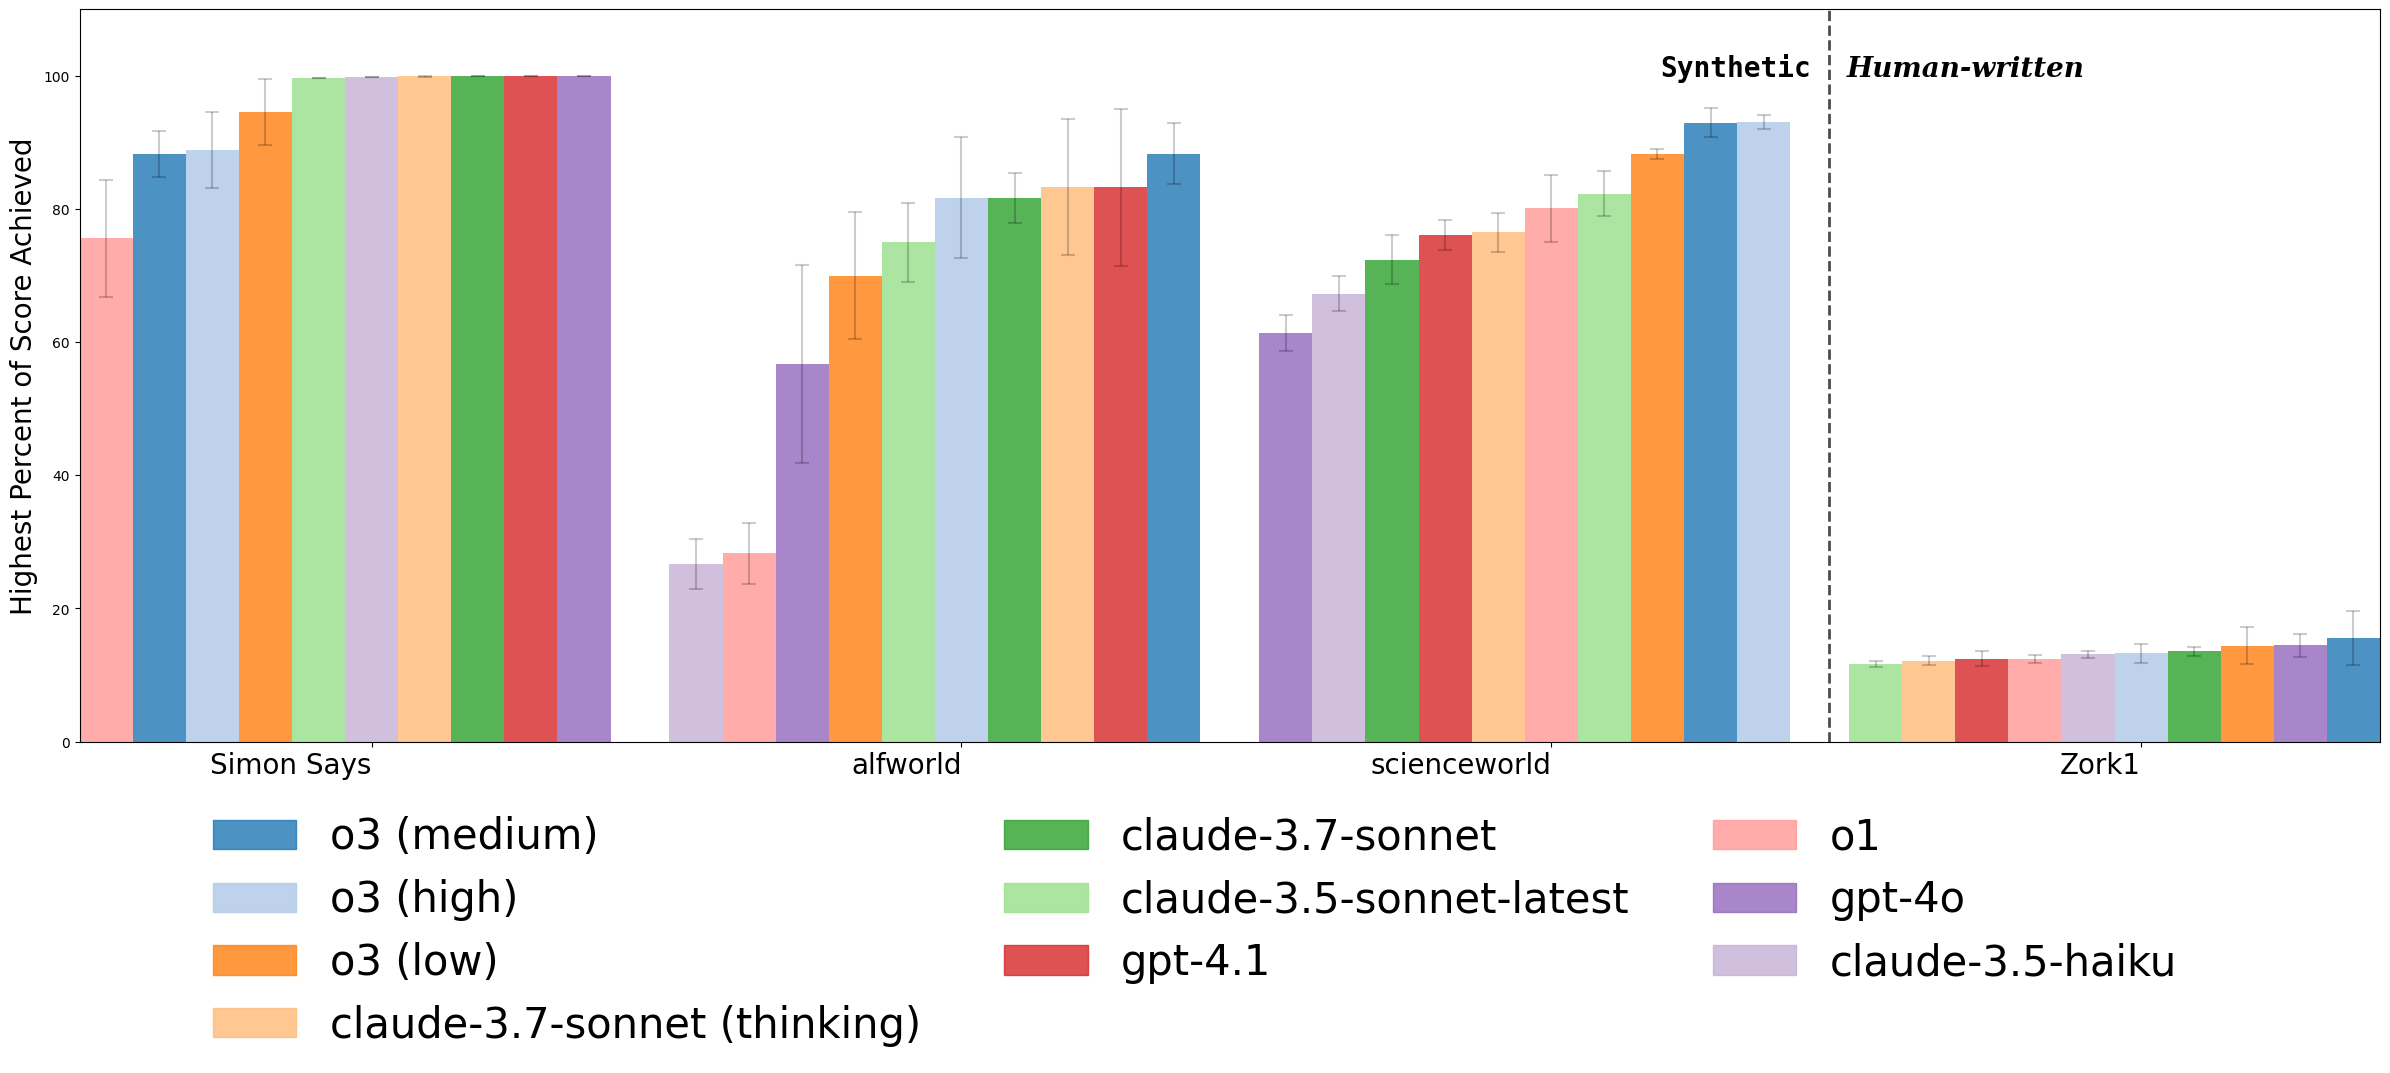

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
def make_bar_chart(llms, frameworks, error_bars = True, name_replacement_dict = {}, divider_idx = -1, plot_name = "bar_chart"):
    framework_indicies = []
    for framework in frameworks:
        if ":" in framework:
            # If there is a : in the framework, get it and split to get the names of all of the games that are to be graphed for that framework
            all_games = framework.split(":")[1].split(",")
            for game in all_games:
                assert game in framework_games[framework.split(":")[0]], f"Game {game} not in frameworks list"
            framework_indicies.append((fws.index(framework.split(":")[0]) + 1, all_games))
        else:
            framework_indicies.append(fws.index(framework) + 1) # +1 to deal with model name offset
    # framework_indicies = sorted(framework_indicies)

    # Filter the scores_per_framework array based on the llms and frameworks
    # Filter the stds_per_framework array based on the llms and frameworks
    filtered_scores_per_framework = {}
    filtered_stds_per_framework = {}
    for i, row in enumerate(scores_per_framework):
        if '*' in row[0]:
            llm_name = row[0].replace("*", "")
        else:
            llm_name = row[0]
        if llm_name not in llms: continue
        new_row_scores = {}
        new_row_stds = {}
        for idx in framework_indicies: 
            if type(idx) == tuple:
                # If the index is a tuple, it means we have multiple games for that framework
                # Get the average score and std for those games
                game_scores = []
                game_stds = []
                for game in idx[1]:
                    framework = fws[idx[0] - 1]
                    game_scores_tokens = llm_framework_scores[llm_name][framework][game]
                    game_scores = []
                    for score_token in game_scores_tokens.values():
                        game_scores.append(score_token[0])

                    if game in name_replacement_dict.keys():
                        game = name_replacement_dict[game]
                    new_row_scores[game] = np.mean(game_scores)
                    new_row_stds[game] = np.std(game_scores, ddof=1)
            elif idx == 2: # Special case for simon says
                for game in framework_games['textworld_express']:
                    if "SimonSays" in game:
                        game_scores_tokens = llm_framework_scores[llm_name]['textworld_express'][game]
                        game_scores = []
                        for score_token in game_scores_tokens.values():
                            game_scores.append(score_token[0])

                        if game in name_replacement_dict.keys():
                            game = name_replacement_dict[game]
                        new_row_scores[game] = np.mean(game_scores)
                        new_row_stds[game] = np.std(game_scores, ddof=1)

            else:
                new_row_scores[fws[idx - 1]] = row[idx]

                # new_row_stds.append(stds_per_framework[i][idx])
                # Calculate the std on a per-run basis
                # Get the games
                framework = fws[idx - 1]
                all_games_scores_tokens = llm_framework_scores[llm_name][framework]
                seeds_scores = {}
                # Get the averages per seed
                for _, seeds in all_games_scores_tokens.items():
                    for seed, score_tokens in seeds.items():
                        if seed not in seeds_scores.keys():
                            seeds_scores[seed] = [score_tokens[0]]
                        else:
                            seeds_scores[seed].append(score_tokens[0])
                summed_scores_per_seeds = []
                for seed, scores in seeds_scores.items():
                    summed_scores_per_seeds.append(np.mean(scores))
                new_row_stds[fws[idx - 1]] = np.std(summed_scores_per_seeds, ddof=1)

        # print(llm_name)
        # print(new_row_scores)
        filtered_scores_per_framework[llm_name] = new_row_scores
        filtered_stds_per_framework[llm_name] = new_row_stds

    new_filtered_scores_per_framework = {}
    for llm, scores in filtered_scores_per_framework.items():
        ss_scores = []
        new_filtered_scores_per_framework[llm] = {}
        for game, score in scores.items():
            if 'SimonSays' in game:
                ss_scores.append(score)
            else:
                new_filtered_scores_per_framework[llm][game] = score

        new_filtered_scores_per_framework[llm]['Simon Says'] = np.mean(ss_scores)

    new_filtered_stds_per_framework = {}
    for llm, stds in filtered_stds_per_framework.items():
        ss_stds = []
        new_filtered_stds_per_framework[llm] = {}
        for game, std in stds.items():
            if 'SimonSays' in game:
                ss_stds.append(std)
            else:
                new_filtered_stds_per_framework[llm][game] = std

        new_filtered_stds_per_framework[llm]['Simon Says'] = np.mean(ss_stds)

    filtered_scores_per_framework = new_filtered_scores_per_framework
    filtered_stds_per_framework = new_filtered_stds_per_framework

    framework_names = []
    for framework in frameworks:
        if ":" not in framework:
            if framework in name_replacement_dict.keys():
                 framework_names.append(name_replacement_dict[framework])
            else:
                framework_names.append(framework)
        else:
            # Get the atcual framework name
            framework_name = framework.split(":")[0]
            # Then add all the games
            for game in framework.split(":")[1].split(","):
                if game in name_replacement_dict.keys():
                    framework_names.append(f"{name_replacement_dict[game]}")
                else:
                    framework_names.append(game)

    # print(filtered_scores_per_framework)
    # print(filtered_stds_per_framework)
    llm_names = llms
    sorted_framework_scores_sets = []
    sorted_framework_std_sets = []
    sorted_llm_names_sets = []
    print(framework_names)

    # Create a list of distinct colors for all LLMs
    base_colors = list(plt.cm.tab20(range(20)))  # First 20 colors from tab20
    more_colors = list(plt.cm.tab20b(range(20))) # Another 20 colors from tab20b
    all_colors = base_colors + more_colors  # Total of 40 colors
    # For each framework, create a mapping from LLM to its color to maintain color consistency
    llm_to_color = {llm: all_colors[i % len(all_colors)] for i, llm in enumerate(llm_names)}

    for framework_name in framework_names:
        # Ensure all LLMs are included, fill with zeros if missing
        sorted_data = []
        for llm in llm_names:
            if "*" in llm:
                llm = llm.replace("*", "")
            if framework_name == 'textworld_express':
                sorted_data.append((filtered_scores_per_framework[llm]['Simon Says'] * 100, filtered_stds_per_framework[llm]['Simon Says'] * 100, llm))
            else:
                sorted_data.append((filtered_scores_per_framework[llm][framework_name] * 100, filtered_stds_per_framework[llm][framework_name] * 100, llm))
                
        # Sort by score
        sorted_data.sort(key=lambda x: x[0])
        
        # Unzip
        sorted_scores, sorted_stds, sorted_llms = zip(*sorted_data)
        sorted_framework_scores_sets.append(sorted_scores)
        sorted_framework_std_sets.append(sorted_stds)
        sorted_llm_names_sets.append(sorted_llms)

    # Create a bar chart
    fig, ax = plt.subplots(figsize=(24, 8))  # Doubled the width from 12 to 24
    
    # Bar width and positions
    # CHANGE HERE: Keep bar width reasonable even with many models
    
    #bar_width = min(0.8 / len(llm_names), 0.54)  # Cap the minimum width to ensure bars are visible
    #print("Bar width:", bar_width)
    bar_width = 1/len(llms) - 0.01
    x = range(len(framework_names))  # X-axis positions for frameworks

    # Create a set to track which LLMs have been added to the legend
    legend_added = set()
    ax.set_ylim(0, 110)  # Set y-axis limits to 0-100 for percentage scores
    ax.margins(x=0)


    for i, (framework_name, sorted_scores, sorted_stds, sorted_llms) in enumerate(zip(
        framework_names, sorted_framework_scores_sets, sorted_framework_std_sets, sorted_llm_names_sets)):
        for j, (llm_name, score, std) in enumerate(zip(sorted_llms, sorted_scores, sorted_stds)):
            # Calculate x position for the bar - ensure all models fit
            x_pos = x[i] + j * bar_width - (len(llm_names) * bar_width) / 2
            
            # Draw the bar
            ax.bar(
                x_pos,
                score,
                width=bar_width,
                label="",  # No labels during bar creation
                color=llm_to_color[llm_name],
                alpha=0.8
            )
            
            if error_bars:
                # Add error bars
                ax.errorbar(
                    x_pos,
                    score,
                    yerr=std,
                    fmt='none',  # No line connecting error bars
                    ecolor='black',  # Color of error bars
                    capsize=5,  # Size of caps at the end of error bars
                    capthick=1.5,  # Thickness of caps
                    elinewidth=1.5,  # Thickness of error bar lines
                    alpha = 0.2
                )

    # Set x-axis labels and ticks with rotation to prevent overlap
    ax.set_xticks(x)
    ax.set_xticklabels(framework_names, rotation=0, ha='right', fontsize=20)  # Add rotation for better readability

    # Add labels and title
    ax.set_ylabel('Highest Percent of Score Achieved', fontsize = 20)
    # ax.set_xlabel('Games(Simon Says, Zork1) and Frameworks(Alfworld, Scienceworld)', fontweight='bold', fontsize=15)
    # ax.set_title('Highest Percent of Score Achieved for Top LLMs', fontweight='bold', fontsize=15)

    # Find index of 'scienceworld' and 'jericho' to place the dividing line
    try:

        jer_idx = divider_idx
        right_most_idx = jer_idx - 1

        # Make sure they're adjacent for the dividing line to make sense
        if jer_idx == right_most_idx + 1:
            # Calculate position between scienceworld and jericho
            divider_x = (x[right_most_idx] + x[jer_idx]) / 2 - 0.03
            
            # Get y-axis limits for the line height
            ymin, ymax = ax.get_ylim()
            line_height = ymax
            
            # Draw vertical divider line
            ax.axvline(x=divider_x, color='black', linestyle='--', linewidth=2, alpha=0.7)
            
            # Add "synthetic" and "human-written" labels
            y_text_pos = ymax * .9  # Position just above the top of the plot
            
            # Calculate positions for synthetic/human-written labels
            # Adjust these offsets to position the text properly
            spacing = 0.03
            synthetic_x = divider_x - spacing
            human_x = divider_x + spacing
            
            ax.text(synthetic_x, y_text_pos, 'Synthetic', ha='right', va='bottom', 
                   fontsize=20, fontweight='bold', fontfamily = 'monospace')
            ax.text(human_x, y_text_pos, 'Human-written', ha='left', va='bottom', 
                   fontsize=20, fontweight='bold', fontstyle='italic', fontfamily='serif')
            
            # Adjust top margin to make room for the labels
            plt.subplots_adjust(top=0.85)
    except ValueError:
        # If either framework isn't in the list, don't add the divider
        print("Note: Could not add divider - scienceworld and jericho must both be in frameworks list")

    # Add legend - placed outside to ensure it's visible and complete
    # Improve legend layout for many items
    legend_handles = []
    legend_labels = []
    for llm in llm_names:  # Use original unsorted order
        legend_handles.append(plt.Rectangle((0,0), 1, 1, color=llm_to_color[llm], alpha=0.8))
        legend_labels.append(llm)
    
    # Add the custom legend
    fig.legend(
        legend_handles, legend_labels,
        title="",
        loc='upper center',
        bbox_to_anchor=(0.5, .02),
        ncol=3,  # Increase number of columns to fit all models
        frameon=False,
        # prop={'weight': 'bold', 'size': 20} 
        prop={'size': 30} 
    )
    
    # Add more padding to ensure everything fits
    plt.tight_layout()
    plt.savefig(plot_name + ".png", bbox_inches='tight', pad_inches=0.8)
    print(plot_name + ".png saved")
    # plt.show()
    # plt.close()

downsampled_llms = [llm.replace("*", "") for llm in selected_llms]
print(downsampled_llms)
print(len(downsampled_llms))
downsampled_llms = ['o3 (high)', 'claude-3.7-sonnet (thinking)', 'gpt-4.1-mini', 'gpt-4.1', 'claude-3.7-sonnet', 'claude-3.5-sonnet-latest', 'gpt-4o', 'o1', 'claude-3.5-haiku', 'Llama-3.1-405B-Instruct', 'gemini-2.0-flash', 'Qwen3-32B', 'Llama-3.1-70B-Instruct', 'Qwen2.5-72B-Instruct', 'Mistral-Large-Instruct-2407']
print(len(downsampled_llms))
name_replacement = {'textworld_express': 'Simon Says', 'JerichoEnvZork1' : 'Zork1'}
tmp = regen_and_filter_df(all_games_required = True, all_seeds_required = False, print_counts = False)
downsampled_frameworks = ['textworld_express', 'alfworld', 'scienceworld', 'jericho:JerichoEnvZork1']
make_bar_chart(llms = downsampled_top_ten_llms, 
                frameworks = downsampled_frameworks,
                error_bars = True, 
                name_replacement_dict = name_replacement,
                divider_idx = 3,
                plot_name = "all_framework_scores")

                # frameworks = fws)

# [['Llama-3.1-70B-Instruct', 1.0, 1.0], ['gpt-4o', 1.0, 1.0], ['Qwen2.5-72B-Instruct', 1.0, 1.0], ['Mistral-Large-Instruct-2407', 0.646, 0.646], ['Mistral-Small-Instruct-2409', 0.288, 0.288], ['Mixtral-8x22B-Instruct-v0.1', 0.128, 0.128], ['Mixtral-8x7B-Instruct-v0.1', 0.029, 0.029], ['gpt-4o-mini', 0.998, 0.998], ['Phi-3-mini-128k-instruct', 0.029, 0.029], ['Llama-3.1-405B-Instruct', 0.848, 0.848], ['Llama-3.2-1B-Instruct', 0.338, 0.338], ['Phi-3-medium-128k-instruct', 0.0, 0.0], ['Phi-3.5-mini-instruct', 0.013, 0.013], ['claude-3.5-sonnet-latest', 0.997, 0.997], ['claude-3.5-haiku', 0.998, 0.998], ['Phi-3.5-MoE-instruct', 0.036, 0.036], ['Ministral-8B-Instruct-2410', 0.406, 0.406], ['phi-4', 0.667, 0.667], ['Llama-3.1-8B-Instruct', 0.562, 0.562], ['Qwen2.5-7B-Instruct', 0.616, 0.616], ['Llama-3.2-3B-Instruct', 0.547, 0.547], ['Mistral-Small-24B-Instruct-2501', 0.176, 0.176], ['Llama-3.3-70B-Instruct', 0.985, 0.985], ['Mistral-Small-3.1-24B-Instruct-2503', 0.072, 0.072], ['gemini-2.0-flash', 1.0, 1.0], ['Llama-4-Scout-17B-16E-Instruct', 0.781, 0.781], ['Llama-4-Maverick-17B-128E-Instruct-FP8', 0.561, 0.561], ['Phi-4-mini-instruct', 0.07, 0.07], ['claude-3.7-sonnet', 1.0, 1.0], ['gpt-4.1', 1.0, 1.0], ['gpt-4.1-nano', 0.421, 0.421], ['gpt-4.1-mini', 0.966, 0.966], ['o1', 0.756, 0.756], ['claude-3.7-sonnet (thinking)', 1.0, 1.0], ['DeepSeek-R1-Distill-Llama-70B', 0.454, 0.454], ['DeepSeek-R1', 0.362, 0.362], ['o3 (high)', 0.887, 0.887], ['Qwen3-32B', 0.799, 0.799]]

Simon Says vs overall score

In [37]:
def calculate_pearson_correlation(items_dict):
    """
    Calculate Pearson correlation coefficient between 'avg' and 'ss' values in a dictionary.
    
    Parameters:
    items_dict -- Dictionary in the format {name: {'avg': value, 'ss': value}, ...}
    
    Returns:
    r -- Pearson correlation coefficient
    """
    # Extract the 'avg' and 'ss' values from the dictionary
    avg_values = [item_data['avg'] for item_data in items_dict.values()]
    ss_values = [item_data['ss'] for item_data in items_dict.values()]
    
    # Number of observations
    n = len(avg_values)
    
    # Check if we have enough data points
    if n < 2:
        return None
    
    # Calculate means
    avg_mean = sum(avg_values) / n
    ss_mean = sum(ss_values) / n
    
    # Calculate the numerator (covariance * n)
    numerator = sum((avg_values[i] - avg_mean) * (ss_values[i] - ss_mean) for i in range(n))
    
    # Calculate the denominators (standard deviations * n)
    avg_variance = sum((x - avg_mean) ** 2 for x in avg_values)
    ss_variance = sum((x - ss_mean) ** 2 for x in ss_values)
    
    # Check for zero variance case
    if avg_variance == 0 or ss_variance == 0:
        return 0  # No correlation if one of the variables doesn't vary
    
    # Calculate Pearson's r
    r = numerator / ((avg_variance * ss_variance) ** 0.5)
    
    return r

print("Pearson correlation: ", calculate_pearson_correlation(llm_avg_ss_scores))

Pearson correlation:  0.8510845101425055


{'Llama-3.1-70B-Instruct': 0.32, 'gpt-4o': 0.406, 'Qwen2.5-72B-Instruct': 0.307, 'Mistral-Large-Instruct-2407': 0.303, 'Mistral-Small-Instruct-2409': 0.148, 'Mixtral-8x22B-Instruct-v0.1': 0.037, 'Mixtral-8x7B-Instruct-v0.1': 0.013, 'gpt-4o-mini': 0.218, 'Phi-3-mini-128k-instruct': 0.022, 'Llama-3.1-405B-Instruct': 0.364, 'Llama-3.2-1B-Instruct': 0.033, 'Phi-3-medium-128k-instruct': 0.007, 'Phi-3.5-mini-instruct': 0.01, 'claude-3.5-sonnet-latest': 0.504, 'claude-3.5-haiku': 0.396, 'Phi-3.5-MoE-instruct': 0.017, 'Ministral-8B-Instruct-2410': 0.046, 'phi-4': 0.103, 'Llama-3.1-8B-Instruct': 0.139, 'Qwen2.5-7B-Instruct': 0.117, 'Llama-3.2-3B-Instruct': 0.104, 'Mistral-Small-24B-Instruct-2501': 0.088, 'Llama-3.3-70B-Instruct': 0.328, 'Mistral-Small-3.1-24B-Instruct-2503': 0.045, 'gemini-2.0-flash': 0.35, 'Llama-4-Scout-17B-16E-Instruct': 0.198, 'Llama-4-Maverick-17B-128E-Instruct-FP8': 0.155, 'Phi-4-mini-instruct': 0.015, 'claude-3.7-sonnet': 0.521, 'gpt-4.1': 0.499, 'gpt-4.1-nano': 0.1, 'gp

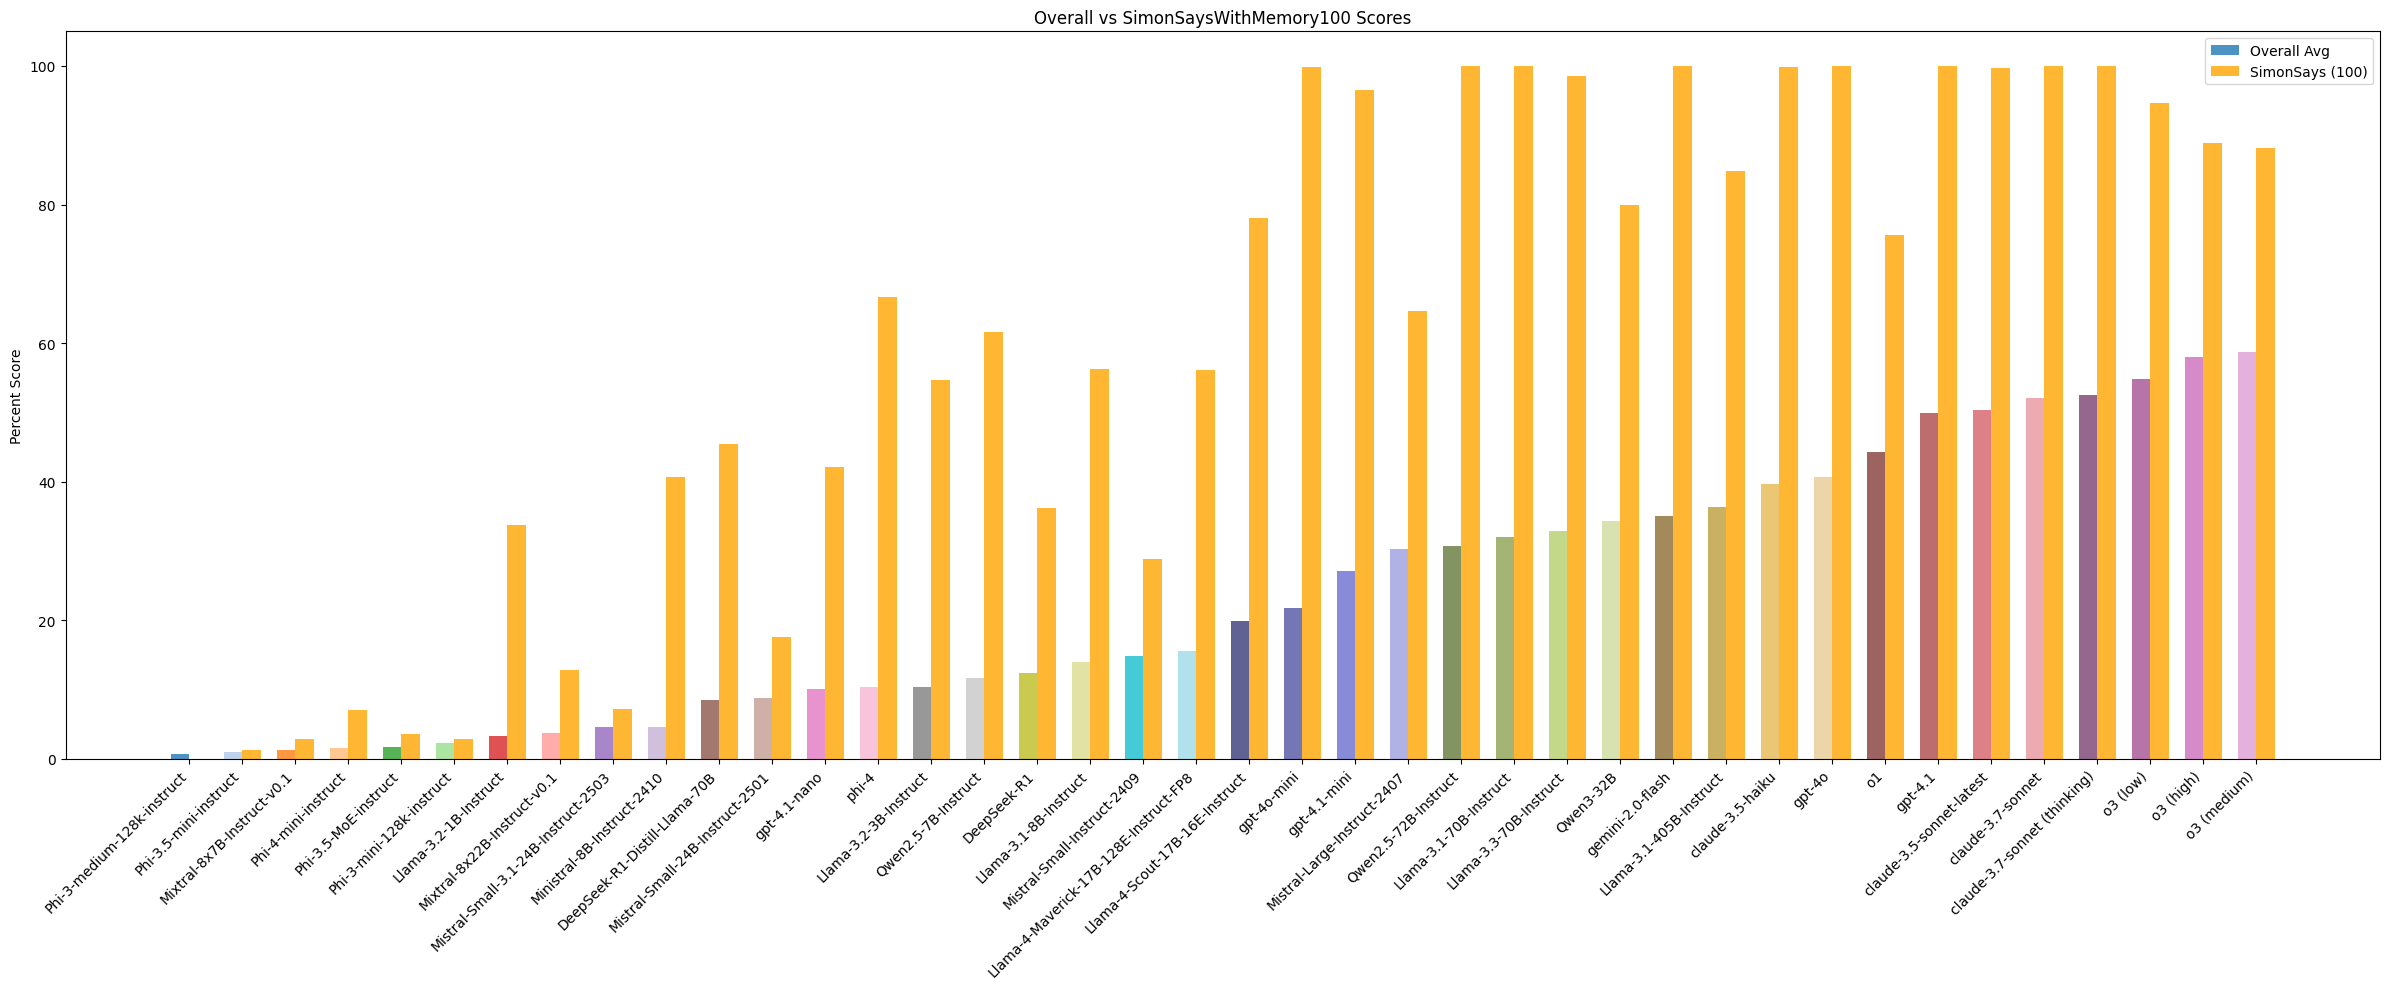

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Assume tmp, fws, llm_framework_scores, scores_per_framework, stds_per_framework are defined as before

def make_bar_chart_dual(llms, name_replacement_dict={}, plot_name="dual_bar_chart"):
    # Prepare containers for overall average and SimonSaysWithMemory100
    overall_scores = {}
    overall_stds = {}
    simon_scores = {}
    simon_stds = {}

    # Assign each LLM a distinct color
    base_colors = list(plt.cm.tab20(range(20)))
    more_colors = list(plt.cm.tab20b(range(20)))
    all_colors = base_colors + more_colors
    llm_to_color = {llm: all_colors[i % len(all_colors)] for i, llm in enumerate(llms)}
    # print(llm_to_color)

    for llm, scores in llms.items():
        overall_scores[llm] = scores['avg']
        simon_scores[llm] = scores['ss']

    # Sort llms by overall average
    sorted_llms = sorted(llms, key=lambda x: overall_scores[x])

    # Set up plot
    fig, ax = plt.subplots(figsize=(24, 10))
    x = np.arange(len(sorted_llms))
    bar_width = 0.35

    # Assign each LLM a distinct color
    base_colors = list(plt.cm.tab20(range(20)))
    more_colors = list(plt.cm.tab20b(range(20)))
    all_colors = base_colors + more_colors
    llm_to_color = {llm: all_colors[i % len(all_colors)] for i, llm in enumerate(sorted_llms)}

    print(overall_scores)
    # Overall bars: one distinct color per LLM
    overall_vals = [overall_scores[llm] * 100 for llm in sorted_llms]
    # overall_errs = [overall_stds[llm] * 100 for llm in sorted_llms]
    overall_colors = [llm_to_color[llm] for llm in sorted_llms]
    ax.bar(
        x - bar_width/2,
        overall_vals,
        width=bar_width,
        label='Overall Avg',
        color=overall_colors,
        alpha=0.8,
        # yerr=overall_errs,
        capsize=5,
        error_kw={'ecolor':'black', 'elinewidth':1.5, 'capsize':5, 'alpha':0.1}
    )

    # SimonSays bars: use a lighter/darker shade of the same LLM colors
    simon_vals = [simon_scores[llm] * 100 for llm in sorted_llms]
    # simon_errs = [simon_stds[llm] * 100 for llm in sorted_llms]
    # Darken each LLM color by blending with black for distinction
    simon_colors = []
    for llm in sorted_llms:
        base = np.array(llm_to_color[llm])
        simon_colors.append(tuple(base * 0.7))  # 70% intensity
    ax.bar(
        x + bar_width/2,
        simon_vals,
        width=bar_width,
        label='SimonSays (100)',
        color='orange',
        alpha=0.8,
        # yerr=simon_errs,
        capsize=5,
        error_kw={'ecolor':'black', 'elinewidth':1.5, 'capsize':5, 'alpha':0.1}
    )

    # Labels and ticks
    ax.set_xticks(x)
    ax.set_xticklabels(sorted_llms, rotation=45, ha='right')
    ax.set_ylabel('Percent Score')
    ax.set_title('Overall vs SimonSaysWithMemory100 Scores')
    ax.legend()

    plt.tight_layout()
    plt.savefig(plot_name + ".png", bbox_inches='tight', pad_inches=0.8)
    plt.show()
    # plt.close()


downsampled_llms = ['o3', 
'claude-3.7-sonnet (react)', 
'claude-3.7-sonnet (zero-shot)', 
'claude-3.5-sonnet-latest', 
'gpt-4.1','o1', 'gpt-4o', 'claude-3.5-haiku', 'Llama-3.1-405B-Instruct', 'gemini-2.0-flash', 
'Qwen3-32B', 'Llama-3.3-70B-Instruct', 'Llama-3.1-70B-Instruct', 'Qwen2.5-72B-Instruct', 'Mistral-Large-Instruct-2407', 'gpt-4.1-mini', 
'gpt-4o-mini']
name_replacement = {'TWXSimonSaysWithMemory100': 'SimonSays with Memory (100)', 'JerichoEnvZork1' : 'Zork1'}
downsampled_frameworks = ['textworld_express:TWXSimonSaysWithMemory100', 'alfworld', 'scienceworld', 'jericho:JerichoEnvZork1']

make_bar_chart_dual(llm_avg_ss_scores, name_replacement_dict=name_replacement, plot_name="dual_bar_chart")


### Horizontal version

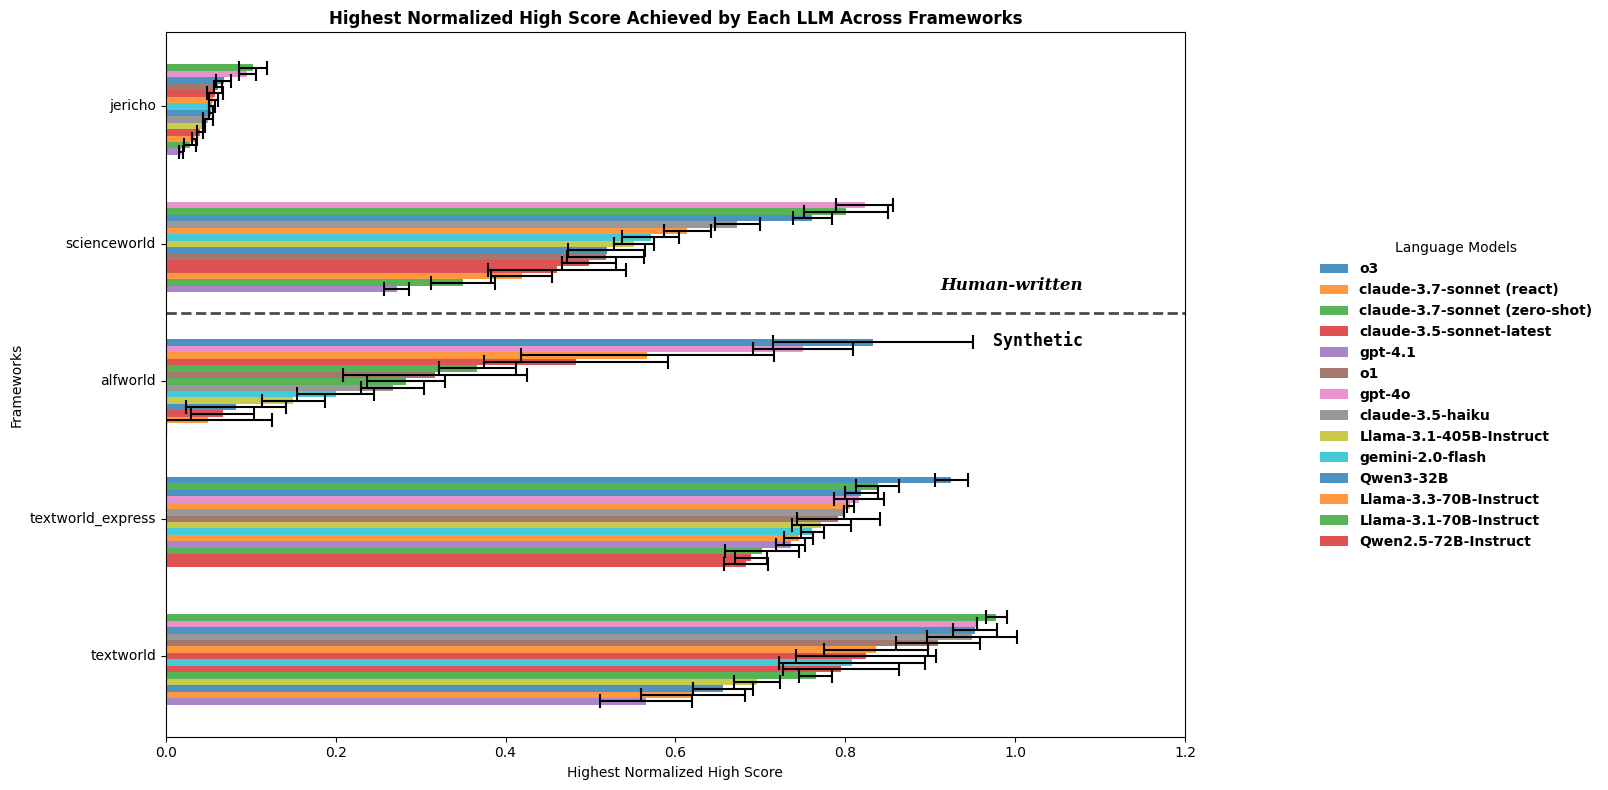

In [39]:
def make_bar_chart_horizontal(llms, frameworks, error_bars = True, name_replacement_dict = {}, divider_idx = -1, height_per_graph = 0.8):
    framework_indicies = []
    for framework in frameworks:
        if ":" in framework:
            # If there is a : in the framework, get it and split to get the names of all of the games that are to be graphed for that framework
            all_games = framework.split(":")[1].split(",")
            for game in all_games:
                assert game in framework_games[framework.split(":")[0]], f"Game {game} not in frameworks list"
            framework_indicies.append((fws.index(framework.split(":")[0]) + 1, all_games))
        else:
            framework_indicies.append(fws.index(framework) + 1) # +1 to deal with model name offset

    # Filter the scores_per_framework array based on the llms and frameworks
    # Filter the stds_per_framework array based on the llms and frameworks
    filtered_scores_per_framework = []
    filtered_stds_per_framework = []
    for i, row in enumerate(scores_per_framework):
        if row[0] not in llms: continue
        new_row_scores = [row[0]]
        new_row_stds = []
        for idx in framework_indicies: 
            if type(idx) == tuple:
                # If the index is a tuple, it means we have multiple games for that framework
                # Get the average score and std for those games
                game_scores = []
                game_stds = []
                for game in idx[1]:
                    framework = fws[idx[0] - 1]
                    game_scores_tokens = llm_framework_scores[row[0]][framework][game]
                    game_scores = []
                    for score_token in game_scores_tokens.values():
                        game_scores.append(score_token[0])

                    new_row_scores.append(np.mean(game_scores))
                    new_row_stds.append(np.std(game_scores))
            else:
                new_row_scores.append(row[idx])
                # new_row_stds.append(stds_per_framework[i][idx])
                # new_row_stds.append(stds_per_framework[i][idx])
                # Calculate the std on a per-run basis
                # Get the games
                framework = fws[idx - 1]
                all_games_scores_tokens = llm_framework_scores[row[0]][framework]
                seeds_scores = {}
                # Get the averages per seed
                for _, seeds in all_games_scores_tokens.items():
                    for seed, score_tokens in seeds.items():
                        if seed not in seeds_scores.keys():
                            seeds_scores[seed] = [score_tokens[0]]
                        else:
                            seeds_scores[seed].append(score_tokens[0])
                summed_scores_per_seeds = []
                for seed, scores in seeds_scores.items():
                    summed_scores_per_seeds.append(np.mean(scores))
                new_row_stds.append(np.std(summed_scores_per_seeds, ddof=1))

        filtered_scores_per_framework.append(new_row_scores)
        filtered_stds_per_framework.append(new_row_stds)

    framework_names = []
    for framework in frameworks:
        if ":" not in framework:
            framework_names.append(framework)
        else:
            # Get the atcual framework name
            framework_name = framework.split(":")[0]
            # Then add all the games
            for game in framework.split(":")[1].split(","):
                if game in name_replacement_dict.keys():
                    framework_names.append(f"{name_replacement_dict[game]}")
                else:
                    framework_names.append(game)


    transposed_std_per_framework = np.transpose(filtered_stds_per_framework)
    llm_names = llms
    framework_scores_sets = []
    framework_std_sets = []
    for i, row in enumerate(np.transpose(filtered_scores_per_framework)[1:]):
        framework_scores_sets.append([float(score) for score in row])
        framework_std_sets.append([float(std) for std in transposed_std_per_framework[i]])
    # Sort scores, standard deviations, and LLM names for each framework
    sorted_framework_scores_sets = []
    sorted_framework_std_sets = []
    sorted_llm_names_sets = []

    # For each framework, create a mapping from LLM to its color to maintain color consistency
    llm_to_color = {llm: plt.cm.tab10(i % 10) for i, llm in enumerate(llm_names)}

    for framework_name, framework_scores, framework_stds in zip(framework_names, framework_scores_sets, framework_std_sets):
        # Pair scores with their corresponding LLM names and standard deviations
        paired_data = list(zip(framework_scores, framework_stds, llm_names))
        
        # Sort the pairs by score
        paired_data.sort(key=lambda pair: pair[0])
        
        # Unzip the sorted pairs back into separate lists
        sorted_scores, sorted_stds, sorted_llms = zip(*paired_data)
        sorted_framework_scores_sets.append(sorted_scores)
        sorted_framework_std_sets.append(sorted_stds)
        sorted_llm_names_sets.append(sorted_llms)

    total_items = len(framework_names)
    height_per_item = height_per_graph  # inches per game/framework
    fig_height = max(8, total_items * height_per_item)

    # Create a bar chart with extra space on right for legend
    fig, ax = plt.subplots(figsize=(14, fig_height))  # Increased width to accommodate legend

    # Bar width and positions
    bar_width = 0.8 / len(llm_names)  # Dynamically adjust bar width based on the number of LLMs
    y = range(len(framework_names))  # Y-axis positions for frameworks

    # Create a set to track which LLMs have been added to the legend
    legend_added = set()

    # Plot bars for each framework
    for i, (framework_name, sorted_scores, sorted_stds, sorted_llms) in enumerate(zip(
        framework_names, sorted_framework_scores_sets, sorted_framework_std_sets, sorted_llm_names_sets)):
        for j, (llm_name, score, std) in enumerate(zip(sorted_llms, sorted_scores, sorted_stds)):
            # Add to legend only if this LLM hasn't been added yet
            if llm_name not in legend_added:
                label = llm_name.split('/')[-1] if '/' in llm_name else llm_name  # Use shorter names
                legend_added.add(llm_name)
            else:
                label = ""
            
            # Calculate y position for the bar
            y_pos = y[i] + j * bar_width - (len(sorted_llms) * bar_width) / 2
            
            # Draw the bar
            ax.barh(
                y_pos,
                score,
                height=bar_width,
                label=label,
                color=llm_to_color[llm_name],
                alpha=0.8
            )
            
            if error_bars:
                # Add error bars
                ax.errorbar(
                    score,
                    y_pos,
                    xerr=std,
                    fmt='none',
                    ecolor='black',
                    capsize=5,
                    capthick=1.5,
                    elinewidth=1.5
                )

    # Set y-axis labels and ticks with 60-degree rotation
    ax.set_yticks(y)
    # ax.set_yticklabels(framework_names, rotation=60, ha='right', va='center')  # 60-degree angle
    ax.set_yticklabels(framework_names, ha='right', va='center')  # 60-degree angle

    # Add labels and title
    ax.set_xlabel('Highest Normalized High Score')
    ax.set_ylabel('Frameworks')
    ax.set_title('Highest Normalized High Score Achieved by Each LLM Across Frameworks', fontweight='bold')
    ax.set_xlim(0, 1.2)

    # Find index of 'scienceworld' and 'jericho' to place the dividing line
    try:
        # Get the index of the right most synthetic framework
        # non_synth_frameworks = ['jericho']
        # right_most_idx = 0
        # for framework_name in framework_names:
        #     idx = framework_names.index(framework_name)
        #     if idx > right_most_idx:
        #         non_synth = False
        #         for non_synth_framework in non_synth_frameworks:
        #             if non_synth_framework in framework_name:
        #                 non_synth = True
        #                 break
        #         if not non_synth:
        #             right_most_idx = idx

        # jer_idx = 0
        # for framework_name in framework_names:
        #     idx = framework_names.index(framework_name)
        #     if 'jericho' in framework_name:
        #         jer_idx = idx
        #         break

        jer_idx = divider_idx
        right_most_idx = jer_idx - 1

        # Make sure they're adjacent for the dividing line to make sense
        if jer_idx == right_most_idx + 1:
            # Calculate position between scienceworld and jericho
            divider_y = (y[right_most_idx] + y[jer_idx]) / 2
            
            # Get x-axis limits for the line width
            xmin, xmax = ax.get_xlim()
            
            # Draw horizontal divider line
            ax.axhline(y=divider_y, color='black', linestyle='--', linewidth=2, alpha=0.7)
            
            # Add "synthetic" and "human-written" labels
            x_text_pos = xmax * 0.9
            
            # Calculate positions for synthetic/human-written labels
            spacing = 0.2
            synthetic_y = divider_y - spacing
            human_y = divider_y + spacing
            
            # Text positioned to the right of the dividing line
            ax.text(x_text_pos, synthetic_y, 'Synthetic', ha='right', va='center', 
                   fontsize=12, fontweight='bold', fontfamily = 'monospace')
            ax.text(x_text_pos, human_y, 'Human-written', ha='right', va='center', 
                   fontsize=12, fontweight='bold', fontstyle='italic', fontfamily='serif')
    except ValueError:
        # If either framework isn't in the list, don't add the divider
        print("Note: Could not add divider - scienceworld and jericho must both be in frameworks list")

    # Add legend to the right side in a single column
    handles, labels = ax.get_legend_handles_labels()
    # Sort to ensure they appear in the original order
    by_label = dict(zip(labels, handles))
    sorted_labels = []
    for llm in llms:
        short_name = llm.split('/')[-1] if '/' in llm else llm
        if short_name in labels:
            sorted_labels.append(short_name)
        
    sorted_handles = [by_label[label] for label in sorted_labels if label in by_label]
    
    # Place legend on the right side in a single column
    fig.legend(
        sorted_handles, sorted_labels,
        title="Language Models",
        loc='center right',
        bbox_to_anchor=(1.15, 0.5),  # Position to the right of the plot
        ncol=1,  # Single column
        frameon=False,
        fontsize='small',
        prop={'weight': 'bold'}
    )

    # Adjust layout - reduce right padding to accommodate the legend
    plt.tight_layout()
    plt.subplots_adjust(right=0.85)  # Leave space on the right for the legend
    
    plt.show()

framework_games['textworld_express']
all_frameworks_by_games = []
for framework, games in framework_games.items():
    all_frameworks_by_games.append(framework + ":" + ",".join(games))

make_bar_chart_horizontal(llms = downsampled_llms, 
                # frameworks = all_frameworks_by_games,
                frameworks = fws,
                error_bars = True, 
                name_replacement_dict = name_replacement,
                divider_idx = 3)

### Make horizontal bar charts per game

In [40]:
  # Assign each LLM a distinct color
base_colors = list(plt.cm.tab20(range(20)))
more_colors = list(plt.cm.tab20b(range(20)))
all_colors = base_colors + more_colors
llm_to_color = {llm: all_colors[i % len(all_colors)] for i, llm in enumerate(all_llms)}

In [51]:
def make_game_bar_charts(llms, framework, games=None, height_per_game = 0.5, plot_name = "placeholder"):
    """
    Creates horizontal bar charts showing LLM performance for each game in a specific framework.
    
    Args:
        llms: List of LLM names to include
        framework: The specific framework to analyze
        games: Optional list of games to include (if None, will use all games in the framework)
    """
    # If no games specified, get all games for the framework
    if games is None:
        games = framework_games[framework]
    
    # Create a figure with subplots - one per game
    n_games = len(games)
    fig_height = n_games * height_per_game  # Dynamic height based on number of games
    fig, axes = plt.subplots(n_games, 1, figsize=(40, fig_height), sharex=True, 
                           constrained_layout=False)
    
    # If there's only one game, make sure axes is still iterable
    if n_games == 1:
        axes = [axes]
    
    # Keep track of the maximum score to set consistent x-axis limits
    max_score = 0
    
    # Process each game
    for game_idx, game in enumerate(games):
        ax = axes[game_idx]
        
        # Collect scores and stds for this game across all LLMs
        game_scores = []
        game_stds = []
        valid_llms = []
        
        for llm in llms:
            try:
                # Get all seeds for this game
                seeds = llm_framework_scores[llm][framework][game]
                
                # Extract scores from all seeds
                scores = [seed_data[0] for seed_data in seeds.values()]
                
                # Calculate mean and std
                mean_score = np.mean(scores)
                std_score = np.std(scores)
                
                game_scores.append(mean_score)
                game_stds.append(std_score)
                valid_llms.append(llm)
                
                # Update max score for x-axis scaling
                if mean_score + std_score > max_score:
                    max_score = mean_score + std_score
                    
            except (KeyError, ValueError):
                # Skip if LLM doesn't have data for this game
                continue
        
        # Sort scores, stds, and LLMs together (highest score first)
        sorted_data = sorted(zip(game_scores, game_stds, valid_llms), key=lambda x: x[0], reverse=False)
        
        # Unpack the sorted data
        if sorted_data:  # Check if there's any data
            sorted_scores, sorted_stds, sorted_llms = zip(*sorted_data)
        else:
            # Skip this game if no data
            ax.set_title(f"{game} (No data)")
            continue
            
        # Set y positions for bars
        y_positions = range(len(sorted_llms))
        
        # Draw horizontal bars
        for i, (llm, score, std) in enumerate(zip(sorted_llms, sorted_scores, sorted_stds)):
            # Draw the bar
            ax.barh(
                i,
                score,
                height=1.0,
                label=llm if game_idx == 0 and i == 0 else "",  # Only add to legend once
                color=llm_to_color[llm],
                alpha=0.8
            )
            
            # Add error bars
            ax.errorbar(
                score,
                i,
                xerr=std,
                fmt='none',
                ecolor='black',
                capsize=5,  # Size of caps at the end of error bars
                capthick=1.5,  # Thickness of caps
                elinewidth=1.5,  # Thickness of error bar lines
                alpha = 0.2
            )
            
            # Add score value at the end of each bar
            ax.text(
                score + std + 0.01,  # Slight offset from end of error bar
                i,
                f"{score:.3f}±{std:.3f}",
                va='center',
                fontsize=8
            )
        
        # Set y-ticks to be the LLM names
        ax.set_yticks(y_positions)
        shortened_llm_names = [llm.split('/')[-1] for llm in sorted_llms]  # Get just the model name without path
        ax.set_yticklabels(shortened_llm_names)
        
        # Set title for this subplot
        ax.set_title(game)
        
        # Add grid lines
        ax.grid(axis='x', linestyle='--', alpha=0.7)
        
        # Only show x-label on the bottom plot
        if game_idx == n_games - 1:
            ax.set_xlabel('Normalized Score')
    
    # Set consistent x-axis limits
    for ax in axes:
        ax.set_xlim(0, max_score * 1.2)  # Add 20% padding
    
    
    # plt.suptitle(f'Performance Across Games in {framework.capitalize()}', fontsize=16, y=0.99)
    plt.tight_layout()
    plt.subplots_adjust(
        hspace=0.1,       # Space between subplots (reduce this if needed)
        # top=2.0,         # Top margin (increase this to move title down)
        bottom=0.05,      # Bottom margin
        left=0.1,         # Left margin
        right=0.9         # Right margin
    )
    
    plt.savefig(plot_name + '.png')
    print("Plot name:", plot_name + '.png')
    # plt.show()
    plt.close()
    
    return fig, axes

# Example usage for one framework
framework_to_analyze = 'scienceworld'  # You can replace with any framework from fws
selected_games = framework_games[framework_to_analyze]  # Limit to first 5 games to avoid overcrowding
framework_save_title = {'textworld_express': 'textworld_express_all_games', 'textworld': 'textworld_all_games', 'alfworld': 'alfworld_all_games', 'scienceworld': 'scienceworld_all_games', 'jericho': 'jericho_all_games'}
# Create the bar charts

for framework, title in framework_save_title.items():
    make_game_bar_charts(
        llms=all_llms, 
        framework=framework,
        games=framework_games[framework],
        height_per_game = 12.0,
        plot_name=title
    )

Plot name: textworld_express_all_games.png
Plot name: textworld_all_games.png
Plot name: alfworld_all_games.png
Plot name: scienceworld_all_games.png
Plot name: jericho_all_games.png


In [56]:
def make_game_bar_charts(llms, framework, games=None, height_per_game=0.5, plot_name="placeholder"):
    """
    Creates horizontal bar charts showing LLM performance for each game in a specific framework.
    
    Args:
        llms: List of LLM names to include
        framework: The specific framework to analyze
        games: Optional list of games to include (if None, will use all games in the framework)
    """
    # If no games specified, get all games for the framework
    if games is None:
        games = framework_games[framework]
    
    # Create a color mapping for LLMs for consistency
    llm_to_color = {llm: plt.cm.tab10(i % 10) for i, llm in enumerate(llms)}
    
    # Create a figure with subplots - one per game
    n_games = len(games)
    fig_height = n_games * height_per_game  # Dynamic height based on number of games
    fig, axes = plt.subplots(n_games, 1, figsize=(12, fig_height), sharex=True, 
                           constrained_layout=False)
    
    # If there's only one game, make sure axes is still iterable
    if n_games == 1:
        axes = [axes]
    
    # Keep track of the maximum score to set consistent x-axis limits
    max_score = 0
    
    # Process each game
    for game_idx, game in enumerate(games):
        ax = axes[game_idx]
        
        # Collect scores and stds for this game across all LLMs
        game_scores = []
        game_stds = []
        valid_llms = []
        
        for llm in llms:
            try:
                # Get all seeds for this game
                seeds = llm_framework_scores[llm][framework][game]
                
                # Extract scores from all seeds
                scores = [seed_data[0] for seed_data in seeds.values()]
                
                # Calculate mean and std
                mean_score = np.mean(scores)
                std_score = np.std(scores)
                
                game_scores.append(mean_score)
                game_stds.append(std_score)
                valid_llms.append(llm)
                
                # Update max score for x-axis scaling
                if mean_score + std_score > max_score:
                    max_score = mean_score + std_score
                    
            except (KeyError, ValueError):
                # Skip if LLM doesn't have data for this game
                continue
        
        # Sort scores, stds, and LLMs together (highest score first)
        sorted_data = sorted(zip(game_scores, game_stds, valid_llms), key=lambda x: x[0], reverse=False)
        
        # Unpack the sorted data
        if sorted_data:  # Check if there's any data
            sorted_scores, sorted_stds, sorted_llms = zip(*sorted_data)
        else:
            # Skip this game if no data
            ax.set_title(f"{game} (No data)")
            continue
            
        # Set y positions for bars
        y_positions = range(len(sorted_llms))
        
        # Draw horizontal bars
        for i, (llm, score, std) in enumerate(zip(sorted_llms, sorted_scores, sorted_stds)):
            # Draw the bar
            ax.barh(
                i,
                score,
                height=0.8,  # Reduced bar height to allow more space for text
                label=llm if game_idx == 0 and i == 0 else "",  # Only add to legend once
                color=llm_to_color[llm],
                alpha=0.8
            )
            
            # Add error bars
            ax.errorbar(
                score,
                i,
                xerr=std,
                fmt='none',
                ecolor='black',
                capsize=3,
                capthick=1,
                elinewidth=1
            )
            
            # Add score value at the end of each bar (now with percentage and split into two lines)
            # Convert to percentage and format
            score_pct = score * 100
            std_pct = std * 100
            
            # Create a two-line label with percentage
            label_score = f"{score_pct:.1f}%"
            label_std = f"±{std_pct:.1f}%"
            
            # Position the text with increased vertical offset for the two lines
            # The key change is increasing the vertical offset (i - 0.25 vs i + 0.25)
            spacing = .35
            ax.text(
                score + std + 0.01,  # Horizontal position
                i - spacing,            # Increased vertical spacing (more negative)
                label_std,
                va='bottom',
                fontsize=6           # Slightly reduced font size
            )
            ax.text(
                score + std + 0.01,  # Same horizontal position
                i + spacing,            # Increased vertical spacing (more positive)
                label_score, 
                va='top',
                fontsize=6           # Slightly reduced font size
            )
        
        # Set y-ticks to be the LLM names
        ax.set_yticks(y_positions)
        shortened_llm_names = [llm.split('/')[-1] for llm in sorted_llms]  # Get just the model name without path
        ax.set_yticklabels(shortened_llm_names)
        
        # Set title for this subplot
        ax.set_title(game)
        
        # Add grid lines
        ax.grid(axis='x', linestyle='--', alpha=0.7)
        
        # Only show x-label on the bottom plot
        if game_idx == n_games - 1:
            ax.set_xlabel('Normalized Score')
    
    # Set consistent x-axis limits and show as percentages
    for ax in axes:
        ax.set_xlim(0, max_score * 1.2)  # Add 20% padding
        
        # Format x-axis ticks as percentages
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
    
    # Adjust the spacing between subplots
    plt.subplots_adjust(
        hspace=0.4,       # Increased space between subplots for better visualization
        bottom=0.15,      # Bottom margin
        left=0.15,        # Left margin for labels
        right=0.85,       # Right margin
        top=0.95          # Top margin
    )
    
    # Save with bbox_inches to ensure nothing is cut off
    plt.savefig(plot_name + '.png', bbox_inches='tight', pad_inches=0.5)
    print("Plot name:", plot_name + '.png')
    plt.close()
    
    return fig, axes

framework_save_title = {'textworld_express': 'textworld_express_all_games', 'textworld': 'textworld_all_games', 'alfworld': 'alfworld_all_games', 'scienceworld': 'scienceworld_all_games', 'jericho': 'jericho_all_games'}
# Create the bar charts

for framework, title in framework_save_title.items():
    make_game_bar_charts(
        llms=downsampled_top_ten_llms, 
        framework=framework,
        games=framework_games[framework],
        height_per_game = 4.0,
        plot_name=title
    )

Plot name: textworld_express_all_games.png
Plot name: textworld_all_games.png
Plot name: alfworld_all_games.png
Plot name: scienceworld_all_games.png
Plot name: jericho_all_games.png


In [43]:
make_game_bar_charts(
        llms=downsampled_llms, 
        framework=framework,
        games=framework_games[framework],
        height_per_game = 4.0,
        plot_name=title
    )

(<Figure size 1200x21600 with 54 Axes>,
 array([<Axes: title={'center': 'JerichoEnvZork1'}>,
        <Axes: title={'center': 'JerichoEnvDetective'}>,
        <Axes: title={'center': 'JerichoEnv905'}>,
        <Axes: title={'center': 'JerichoEnvAcorncourt'}>,
        <Axes: title={'center': 'JerichoEnvAdvent'}>,
        <Axes: title={'center': 'JerichoEnvAdventureland'}>,
        <Axes: title={'center': 'JerichoEnvAfflicted'}>,
        <Axes: title={'center': 'JerichoEnvAnchor'}>,
        <Axes: title={'center': 'JerichoEnvAwaken'}>,
        <Axes: title={'center': 'JerichoEnvBalances'}>,
        <Axes: title={'center': 'JerichoEnvBallyhoo'}>,
        <Axes: title={'center': 'JerichoEnvCurses'}>,
        <Axes: title={'center': 'JerichoEnvCutthroat'}>,
        <Axes: title={'center': 'JerichoEnvDeephome'}>,
        <Axes: title={'center': 'JerichoEnvDragon'}>,
        <Axes: title={'center': 'JerichoEnvEnchanter'}>,
        <Axes: title={'center': 'JerichoEnvEnter'}>,
        <Axes: tit

## New Code: Experimental

Get the top llm per game

In [ ]:
tmp = regen_and_filter_df(all_games_required = True, all_seeds_required = True, print_counts = False)
print(tmp.keys())

In [ ]:
all_fws = tmp['framework'].unique()
framework_best_llm = {}
for fw in all_fws:
    llm_scores = tmp[tmp['framework'] == fw]
    framework_scores = llm_scores.groupby("llm")['episode/normalized_highscore'].mean().reset_index()
    top_score_row = framework_scores['episode/normalized_highscore'].idxmax()
    top_llm = framework_scores.loc[top_score_row, 'llm']
    framework_best_llm[fw] = top_llm    

print(framework_best_llm)

In [ ]:
def save_optimal_logs(base_path = '/root/trajectories/'):
    all_convos = {}
    for framework, llm in framework_best_llm.items():
        for data in filtered_runs_data:
            if data['llm'] == llm and data['framework'] == framework:
                convo_dict = {}
                for i, step in enumerate(data['rollout']):
                    turn = {}
                    turn['user'] = step[5]
                    turn['assistant'] = step[6]
                    convo_dict["step " + str(i)] = turn
                # Save the conversation to a JSON file 
                uid = data['game']  + "_" + llm.split("/")[-1] + "_" + str(data['seed'])
                with open(base_path + uid +  ".json", 'w') as f:
                    json.dump(convo_dict, f, indent=4)  
                if data['game'] not in all_convos.keys():
                    all_convos[data['game']] = {}
                all_convos[data['game']][str(data['seed']) + "_" + str(data['episode/normalized_highscore'])] = convo_dict
    with open(base_path + "all_trajs.json", 'w') as f:
        json.dump(all_convos, f, indent=4)
    return all_convos
                
all_convos = save_optimal_logs()

In [ ]:
def get_partial_trajectories(base_path = '/root/trajectories/'):
    all_datapoints = {}
    longed_convo = 0
    for framework, llm in framework_best_llm.items():
        data_points = []
        for data in filtered_runs_data:
            if data['llm'] == llm and data['framework'] == framework:
                convo_history = ""
                for i, step in enumerate(data['rollout']):
                    convo_history += step[5] + "\n"
                    data_dict = {'prompt': convo_history, 'response': step[6]}
                    convo_history += step[6] + "\n"
                    data_points.append(data_dict)
                    if len(convo_history) > longed_convo: longed_convo = len(convo_history)

        all_datapoints[framework] = data_points
    print("Longest trajectory:", longed_convo)
    return all_datapoints

all_datapoints = get_partial_trajectories()
total = 0
for framework, data_points in all_datapoints.items():
    print(f'{framework}: {len(data_points)} data points')
    total += len(data_points)
print(f'Total data points: {total}')


In [ ]:
def create_data_splits(data, test_percent = .2, subsample_train = 1, save_path = '/root/'):
    test_set = []
    train_set = []
    random.seed(12)
    for datum in data:
        random.shuffle(datum)
        split_index = int(len(datum) * test_percent)
        test_set += datum[:split_index]
        train_set += datum[split_index:]

    random.shuffle(train_set)
    random.shuffle(test_set)

    with open("test.jsonl", "w") as jsonl_file:
        for item in test_set:
            jsonl_file.write(json.dumps(item) + "\n")
    
    with open("valid.jsonl", "w") as jsonl_file:
        for item in test_set:
            jsonl_file.write(json.dumps(item) + "\n")

    split_index = int(len(train_set) * subsample_train)
    with open("train.jsonl", "w") as jsonl_file:
        for item in train_set[:split_index]:
            jsonl_file.write(json.dumps(item) + "\n")
    print("Train set:", len(train_set[:split_index]))
    print("Test set:", len(test_set))

create_data_splits(list(all_datapoints.values()), subsample_train=.5)

In [ ]:
import random
num_runs = 0
num_traj = 0
avg_last_rewarded_step = 0
rewarded_trajs = 0
filtered_runs_data = tmp.to_dict(orient='records')
data = random.choice(filtered_runs_data)
print(data.keys())
all_frameworks = tmp['framework'].unique()
all_llms = tmp['llm'].unique()
print(all_frameworks)
# Could just do tmp['framework'].unique() but this enforces ordering
fws = ['textworld', 'textworld_express', 'alfworld', 'scienceworld', 'jericho']
# store everything in a dictionary of the form {llm: {framework: {game: {seed: best_score}}}}
llm_framework_steps = {} 

# Iniitialize the LLM layer of the dictionary
for llm in all_llms:
    llm_framework_steps[llm] = {}

# Initialize the framework layer of the dictionary
for framework in fws:
    for llm in all_llms:
        llm_framework_steps[llm][framework] = {}   

# For game and seeds, its easier to just iterate through the filtered_runs_data
for data in filtered_runs_data:
    game = data['game']
    seed = data['seed']

    if game not in llm_framework_steps[data['llm']][data['framework']].keys():
        llm_framework_steps[data['llm']][data['framework']][game] = {}

    tokens_used = data['episode/token_usage']
    resets = 1
    score_changed_from_0 = False
    for step in data['rollout']:
        score = step[3]
        if score != 0:
            score_changed_from_0 = True
        if score == 0 and score_changed_from_0:
            score_changed_from_0 = False
            resets += 1
    llm_filtered = tmp[tmp['llm'] == llm]
    num_steps = len(data['rollout'])/(data['total/Resets'] + 1)
    llm_framework_steps[data['llm']][data['framework']][game][seed] = num_steps

rows = {}
for llm in all_llms:
    model = llm.split("/")[-1]
    rows[model] = []
    row = []
    for framework in fws:
        relevant_games = llm_framework_steps[llm][framework]
        all_fw_game_steps = []
        for game, seeds in relevant_games.items():
            all_fw_game_steps += list(seeds.values())
        row.append(np.mean(all_fw_game_steps))
    row.append(np.mean(row))
    rows[model] += row
    
print("Full trajectory")
print("==========================Scores==============================")
max_model_len = max([len(row[0]) for row in formatted_rows])
print("Model, Textworld, Textworld_express, Alfworld, Scienceworld, Jericho, Overall")
num_models = 8
for row in formatted_rows[:num_models]:
    scores = " & " +  " & ".join(row[1:])
    print(f"{row[0]:<{max_model_len + 2}} {scores} \\\\")

# # Padding them to have the &s line up because it makes my ocd happy
formatted_rows_steps = []
for row in formatted_rows:
    model = row[0].split("/")[-1]
    row1 = rows[row[0]]
    formattedRows1 = [model]
    for score in row1:
        formattedRows1.append(cast_to_str(cast_to_float(round(score, 1)), 1))
    formatted_rows_steps.append(formattedRows1)

print("==========================Steps==============================")
for row in formatted_rows_steps[:num_models]:
    model = row[0].split("/")[-1]
    scores = " & " +  " & ".join(row[1:])
    print(f"{model:<{max_model_len + 2}} {scores} \\\\")




### Get per-action difference between games for claude

In [ ]:
tmp = regen_and_filter_df(all_games_required = True, all_seeds_required = True, print_counts = True)
print(tmp.keys())

In [ ]:
thinking = tmp[tmp['llm'] == 'claude-3.7-sonnet (react)']
zero_shot = tmp[tmp['llm'] == 'claude-3.7-sonnet (zero-shot)']
latest = tmp[tmp['llm'] == 'claude-3.5-sonnet-latest']

In [ ]:
def levenshtein_distance(array1, array2):
    """
    Calculate the Levenshtein distance between two arrays.
    
    Args:
        array1: The first array/list
        array2: The second array/list
        
    Returns:
        int: The Levenshtein distance
    """
    # Create a matrix of size (len(array1) + 1) x (len(array2) + 1)
    rows, cols = len(array1) + 1, len(array2) + 1
    dist_matrix = [[0 for _ in range(cols)] for _ in range(rows)]
    
    # Initialize the first row and column
    for i in range(rows):
        dist_matrix[i][0] = i
    for j in range(cols):
        dist_matrix[0][j] = j
    
    # Fill the matrix using dynamic programming
    for i in range(1, rows):
        for j in range(1, cols):
            # If elements are equal, no operation needed
            if array1[i-1] == array2[j-1]:
                cost = 0
            else:
                cost = 1
                
            # Choose the minimum cost operation (insertion, deletion, substitution)
            dist_matrix[i][j] = min(
                dist_matrix[i-1][j] + 1,      # deletion
                dist_matrix[i][j-1] + 1,      # insertion
                dist_matrix[i-1][j-1] + cost  # substitution or match
            )
    
    # The bottom-right value contains the Levenshtein distance
    return dist_matrix[rows-1][cols-1]

In [ ]:
def analyze_claude():
    all_seeds = zero_shot['seed'].unique()
    print(all_seeds)
    total = 0
    all_distances = []
    thinking_unique_acts = []
    zero_shot_unique_acts = []
    for framework, games in framework_games.items():
        print(framework)
        for game in games:
            thinking_games = thinking[thinking['game'] == game]
            zs_games = zero_shot[zero_shot['game'] == game]
            latest_games = latest[latest['game'] == game]
            for seed in all_seeds:
                seed = int(seed)
                thinking_game_seed = thinking_games[thinking_games['seed'] == seed]
                zs_game_seed = zs_games[zs_games['seed'] == seed]
                latest_game_seed = latest_games[latest_games['seed'] == seed]
                thinking_rollout = thinking_game_seed['rollout'].values[0]
                zeros_rollout = zs_game_seed['rollout'].values[0]
                latest_rollout = latest_games['rollout'].values[0]

                # Get action trajectories
                think_acts = []
                zero_acts = []
                latest_acts = []
                top_think_score = 0
                top_zero_score = 0
                for i, step in enumerate(thinking_rollout):
                    # Get action
                    think_acts.append(step[6])

                    # Get normalized score
                    if top_think_score < step[3]:
                        top_think_score = step[3]


                for i, step in enumerate(zeros_rollout):
                    zero_acts.append(step[6])

                     # Get normalized score
                    if top_zero_score < step[3]:
                        top_zero_score = step[3]

                for i, step in enumerate(latest_rollout):
                    latest_acts.append(step[6])

                # print(think_acts)
                # print(top_think_score)
                # print(zero_acts)
                # print(top_zero_score)

                # Full trajectories
                # zero_shot_unique_acts.append(len(set(zero_acts)))
                # thinking_unique_acts.append(len(set(think_acts)))

                all_distances.append(levenshtein_distance(think_acts, zero_acts))
                if all_distances[-1] > 61.55:
                    # Second half:
                    if len(zero_acts) > 90:
                        zero_shot_unique_acts.append(len(set(zero_acts[len(zero_acts)//2:])))
                    if len(think_acts) > 90:
                        thinking_unique_acts.append(len(set(think_acts[len(think_acts)//2:])))
                    total += 1
                    print("________________________________________________________________________________________")
                    print(f'Game: {game} Distance: {all_distances[-1]} Total: {total} Think Length: {len(think_acts)} Zero Length: {len(zero_acts)} Think Score: {top_think_score} Zero Score: {top_zero_score}')
                    print("\n")
                    print("think actions:", think_acts)
                    print("\n")
                    print("zero actions:", zero_acts)
                    print("\n")
                    print("latest actions:", latest_acts)

                    print("________________________________________________________________________________________")

    print(np.mean(all_distances))
    print(np.std(all_distances))
    print(np.max(all_distances))
    print(np.min(all_distances))
    print("Unique acts:")
    print(np.mean(thinking_unique_acts))
    print(np.std(thinking_unique_acts))
    print(np.max(thinking_unique_acts))
    print(np.min(thinking_unique_acts))
    print(len(thinking_unique_acts))
    print("_________________________________________")
    print(np.mean(zero_shot_unique_acts))
    print(np.std(zero_shot_unique_acts))
    print(np.max(zero_shot_unique_acts))
    print(np.min(zero_shot_unique_acts))
    print(len(zero_shot_unique_acts))
            
analyze_claude()

In [ ]:
def analyze_claude_unique_acts(traj_len_cutoff):
    all_seeds = zero_shot['seed'].unique()
    print(all_seeds)
    total = 0
    all_distances = []
    thinking_unique_acts = []
    zero_shot_unique_acts = []
    for framework, games in framework_games.items():
        print(framework)
        if framework != 'scienceworld':
            continue
        for game in games:
            thinking_games = thinking[thinking['game'] == game]
            zs_games = zero_shot[zero_shot['game'] == game]
            for seed in all_seeds:
                seed = int(seed)
                thinking_game_seed = thinking_games[thinking_games['seed'] == seed]
                zs_game_seed = zs_games[zs_games['seed'] == seed]
                thinking_rollout = thinking_game_seed['rollout'].values[0]
                zeros_rollout = zs_game_seed['rollout'].values[0]

                # Get action trajectories
                think_acts = []
                zero_acts = []
                top_think_score = 0
                top_zero_score = 0
                for i, step in enumerate(thinking_rollout):
                    # Get action
                    think_acts.append(step[6])

                    # Get normalized score
                    if top_think_score < step[3]:
                        top_think_score = step[3]


                for i, step in enumerate(zeros_rollout):
                    zero_acts.append(step[6])

                     # Get normalized score
                    if top_zero_score < step[3]:
                        top_zero_score = step[3]

                # print(think_acts)
                # print(top_think_score)
                # print(zero_acts)
                # print(top_zero_score)

                # Full trajectories
                # zero_shot_unique_acts.append(len(set(zero_acts)))
                # thinking_unique_acts.append(len(set(think_acts)))

                #Second half:
                # if top_zero_score < 1 or top_think_score < 1:
                #     if len(zero_acts) > traj_len_cutoff:
                #         zero_shot_unique_acts.append(len(set(zero_acts[int(len(zero_acts) * .9):])))
                #     if len(think_acts) > traj_len_cutoff:
                #         thinking_unique_acts.append(len(set(think_acts[int(len(think_acts) * .9):])))
                # if len(zero_acts) < traj_len_cutoff:
                #     zero_shot_unique_acts.append(len(set(zero_acts)))
                # if len(think_acts) < traj_len_cutoff:
                #     thinking_unique_acts.append(len(set(think_acts)))
                all_distances.append(levenshtein_distance(think_acts, zero_acts))
                if all_distances[-1] > 60.55:
                    # Second half:
                    if len(zero_acts) > 50:
                        zero_shot_unique_acts.append(len(set(zero_acts[len(zero_acts)//2:])))
                    if len(think_acts) > 50:
                        thinking_unique_acts.append(len(set(think_acts[len(think_acts)//2:])))
                        
    return thinking_unique_acts, zero_shot_unique_acts
            
think_ua_all = []
zero_ua_all = []
x_axis = []
for i in range(11):
    think_ua, zero_ua = analyze_claude_unique_acts(i * 10)
    think_ua_all.append(np.mean(think_ua))
    zero_ua_all.append(np.mean(zero_ua))
    x_axis.append(i * 10 + 1)




In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create x-axis values (the cutoff values used: 0, 10, 20, ..., 90)
x_values = x_axis

# Create the figure and axis
plt.figure(figsize=(10, 6))

# Plot both lines
plt.plot(x_values, think_ua_all, marker='o', linestyle='-', linewidth=2, label='Thinking')
plt.plot(x_values, zero_ua_all, marker='s', linestyle='-', linewidth=2, label='Zero-shot')

# Add labels and title
plt.xlabel('Min game length', fontsize=12)
plt.ylabel('Average Number of Unique Actions', fontsize=12)
plt.title('Comparison of Unique Actions: Thinking vs. Zero-shot: 2nd Half of Trajectory', fontsize=14)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(0, 90)
plt.ylim(0, 60)

# Add legend
plt.legend(fontsize=12)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# # If you want to save the figure
# plt.savefig('unique_actions_comparison.png', dpi=300, bbox_inches='tight')

In [ ]:
!pip install llm-anthropic

In [ ]:
import importlib.util
import sys
import llm as sw_llm

# Specify the absolute path to the module
file_path = "/root/text-games-benchmark/tales/token.py"

# Get the module specification
spec = importlib.util.spec_from_file_location("ClaudeTokenCounter", file_path)

# Create the module
module = importlib.util.module_from_spec(spec)

# Add the module to sys.modules
sys.modules["ClaudeTokenCounter"] = module

# Execute the module
spec.loader.exec_module(module)

# Now you can use the class from that module
ctc = module.ClaudeTokenCounter(sw_llm.get_model('claude-3.7-sonnet'))

In [ ]:
tmp = regen_and_filter_df(all_games_required = True, all_seeds_required = True, print_counts = False)
thinking = tmp[tmp['llm'] == 'claude-3.7-sonnet (react)']
# framework, game, seed:
framework_game_seeds = {}
def analyze_claude_thinking_tokens():
    all_seeds = thinking['seed'].unique()
    print(all_seeds)
    all_thinks = []
    hit_max = []
    for framework, games in framework_games.items():
        print(framework)
        framework_game_seeds[framework] = {}
        for game in games:
            framework_game_seeds[framework][game] = {}
            thinking_games = thinking[thinking['game'] == game]
            for seed in all_seeds:
                seed = int(seed)
                thinking_game_seed = thinking_games[thinking_games['seed'] == seed]
                thinking_rollout = thinking_game_seed['rollout'].values[0]

                thinking_tokens_per_step = []
                # Get action trajectories
                for i, step in enumerate(thinking_rollout):
                    thinking_tokens_per_step.append(ctc(text = step[-2]))
                    if thinking_tokens_per_step[-1] > 1000:
                        hit_max.append(thinking_tokens_per_step[-1])

                framework_game_seeds[framework][game][seed] = thinking_tokens_per_step
                all_thinks += thinking_tokens_per_step
    return framework_game_seeds, all_thinks, hit_max


framework_game_seeds, all_thinks, hitmax = analyze_claude_thinking_tokens()

In [ ]:
import pickle

with open('hit_max.pickle', 'wb') as file:
    pickle.dump(np.array(hitmax), file)
    

# Save array to pickle file
with open('fwgs.pickle', 'wb') as file:
    pickle.dump(np.array(all_thinks), file)
    
# print(f"Array saved to pickle file: {array_to_save}")

# # To verify, let's load it back
# with open('array.pickle', 'rb') as file:
#     loaded_array = pickle.load(file)
    
# print(f"Array loaded from pickle file: {loaded_array}")

In [ ]:
with open("data.json", "w") as file:
    json.dump(framework_game_seeds, file, indent=4)

In [ ]:
import json
with open("data.json", 'r') as file:
    framework_game_seeds = json.load(file)

In [ ]:
print(framework_game_seeds['jericho']['JerichoEnvZork1'].values())

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create x-axis values (the cutoff values used: 0, 10, 20, ..., 90)
plot_scores = list(framework_game_seeds['jericho']['JerichoEnvZork1'].values())[0]
x_values = []
for i, score in enumerate(plot_scores):
    x_values.append(i + 1)

# Create the figure and axis
plt.figure(figsize=(10, 6))

# Plot both lines
plt.plot(x_values, plot_scores, marker='o', linestyle='-', linewidth=2, label='Thinking')

# Add labels and title
plt.xlabel('Steps', fontsize=12)
plt.ylabel('thinking tokens', fontsize=12)
plt.title('Claude 3.7 thinking tokens per step', fontsize=14)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(0, 100)
plt.ylim(0, 300)

# Add legend
plt.legend(fontsize=12)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
import pandas as pd
import wandb
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("pearls-lab/tales")
run_cutoff = "2024-02-0"
runs_data = []
for run in runs:
    # if 'without-help' not in run.tags:
    run_data = dict(run.summary)
    run_data.update(run.config)
    run_data['tags'] = run.tags
    run_data['run_object'] = run
    run_data["agent"] = run.config["agent"]
    run_data["game"] = run.config["game"]
    runs_data.append(run_data)
print(len(runs_data))
runs_df = pd.DataFrame(runs_data)

In [ ]:
import re
fulls = []
for key in runs_df['llm'].unique():
    if pd.notna(key):
        if 'half' in key:
            fulls.append(key)
sorted(fulls, key=lambda path: int(re.search(r'ba(\d+)', path).group(1)))

In [ ]:
target_llms = ['/root/checkpoints/ba1000',
       '/root/checkpoints/half/ba2000', '/root/checkpoints/half/ba3000',
       '/root/checkpoints/half/ba4000', '/root/checkpoints/half/ba5000',
       '/root/checkpoints/full/ba670', '/root/checkpoints/full/ba1340',
       '/root/checkpoints/full/ba2010', '/root/checkpoints/full/ba2345']
fws = runs_df['framework'].unique()
score_dict = {}
for llm in target_llms:
      score_dict[llm] = {}
      for framework in fws:
            score_dict[llm][framework] = {}

for llm in target_llms:
    llm_filtered = runs_df[runs_df['llm'] == llm]
    avg_games_per_score = llm_filtered.groupby("framework")['episode/normalized_highscore'].mean().reset_index()
    avg_games_per_score.columns = ["framework", "episode/normalized_highscore"]
    for framework in fws:
           score_dict[llm][framework] = avg_games_per_score[avg_games_per_score['framework'] == framework]['episode/normalized_highscore'].values[0]

print(score_dict)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

half_step = 500
full_step = 335
half_order = ['ba1000', 'ba2000', 'ba3000', 'ba4000', 'ba5000']
full_order = ['ba670', 'ba1340', 'ba2010', 'ba2345']
specific_framework = 'TALES'
starting_score = 0.139
half_scores = {'ba0': starting_score}
for llm in half_order:
    if llm == 'ba1000':
        key = '/root/checkpoints/' + llm
    else:
        key = '/root/checkpoints/half/' + llm
    if specific_framework == 'TALES':
        scores = list(score_dict[key].values())
    else:
        scores = [score_dict[key][specific_framework]]
    half_scores[llm] = np.mean(scores)

full_scores = {'ba0': starting_score}
for llm in full_order:
    key = '/root/checkpoints/full/' + llm
    if specific_framework == 'TALES':
        scores = list(score_dict[key].values())
    else:
        scores = [score_dict[key][specific_framework]]
    full_scores[llm] = np.mean(scores)
    
import matplotlib.pyplot as plt
import numpy as np

# Define the data as dictionaries
data1 = full_scores
data2 = half_scores

# Extract steps and scores from the dictionaries
steps1 = [int(key[2:])/full_step for key in data1.keys()]
scores1 = list(data1.values())

steps2 = [int(key[2:])/half_step for key in data2.keys()]
scores2 = list(data2.values())

# Create the plot
plt.figure(figsize=(10, 6))

# Plot both sets of data
plt.plot(steps1, scores1, 'o-', color='blue', label='Full Data')
plt.plot(steps2, scores2, 's-', color='red', label='Half Data')

# Add labels and title
plt.xlabel('epochs')
plt.ylabel('Score')
plt.title(specific_framework + ' Scores vs. Epochs Trained')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Ensure x-axis starts from 0 and extends a bit beyond the last point
plt.xlim(0, max(max(steps1), max(steps2)) * 1.1)

# Show the plot
plt.tight_layout()
plt.show()

# You can also save the plot to a file
# plt.savefig('scores_plot.png', dpi=300, bbox_inches='tight')